![Banner](../img/banner/banner.png)


# 02 - preprocesamiento EDA

## Descripción
Este notebook tiene como objetivo realizar un pre procesamiento y analisis EDA de las variables para encontrar patrones que nos permitan identificar que caracteristicas influyen y el como influyen sobre los productos nuevo/usado

In [ ]:
import torch
print(torch.cuda.is_available())  # True si la GPU está activa
print(torch.cuda.get_device_name(0))  # Modelo de la GPU

True
Tesla T4


# 1 - Dependencias:

### 1.1 Instalación de dependencias

In [ ]:
# # NPL Clasic
# !pip install spacy
# # Transformer
# !pip install sentence_transformers
# !pip install faiss-cpu
# #python -m spacy download es_core_news_lg # model large
# !python -m spacy download es_core_news_sm # model small

### 1.2 Importación de dependencias

In [ ]:
# Complementos
import warnings
from pathlib import Path
import gc

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Pre-procesamiento
from typing import List
import re
import json
import ast
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn.impute import KNNImputer

# NPL Clasic
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from collections import Counter

# Transformers
import faiss
import torch
from sentence_transformers import SentenceTransformer

### 1.3 Conexión a Datasets desde Google Drive

In [ ]:
from google.colab import files
from google.colab import drive

### 1.4 Constantes

In [ ]:
categorias_MELI = [
        "Accesorios para Vehículos", "Agro", "Alimentos y Bebidas", "Animales y Mascotas", "Antiguedades y Colecciones",
        "Arte, Papelería y Mercería", "Bebés", "Belleza y Cuidado Personal", "Boletas para Espectáculos",
        "Cámaras y Accesorios", "Carros, Motos y Otros", "Celulares y Teléfonos", "Computación",
        "Consolas y Videojuegos", "Construcción", "Deportes y Fitness", "Electrodomésticos",
        "Electrónica, Audio y Video", "Herramientas", "Hogar y Muebles", "Industrias y Oficinas",
        "Inmuebles", "Instrumentos Musicales", "Juegos y Juguetes", "Libros, Revistas y Comics",
        "Música, Películas y Series", "Recuerdos, Piñatería y Fiestas", "Relojes y Joyas",
        "Ropa y Accesorios", "Salud y Equipamiento Médico", "Servicios", "Otras categorías"
    ]

# 2 - Funciones:

### 2.1 Funciones de carga datasets

In [ ]:
def build_dataset(path):
    data = [json.loads(x) for x in open(path)]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

### 2.2 Funciones de NPL Clasicas

In [ ]:
# nltk.download('stopwords')
# nltk.download('punkt')

# nlp_es = spacy.load("es_core_news_sm")
# nlp_en = spacy.load("en_core_web_sm")

# def remove_stopwords(text: str, language: str = 'spanish', keep_words: List[str] = []) -> str:
#     """
#       Elimina stopwords del texto en el idioma seleccionado, excluye palabras clave.

#       Args:
#           text (str): Texto de entrada.
#           language (str): Idioma de las stopwords ('spanish', 'english', etc.).
#           keep_words (List[str]): Lista de palabras que no deben ser eliminadas.

#       Returns:
#           str: Texto sin stopwords.
#     """
#     stop_words = set(stopwords.words(language))
#     stop_words.difference_update(keep_words)  # Asegura que las palabras en keep_words no sean eliminadas
#     return ' '.join([word for word in text.split() if word.lower() not in stop_words])

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

nlp_es = spacy.load("es_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

def remove_stopwords(text, language='spanish', keep_words=[]):
    """Elimina stopwords del texto en español o inglés, excepto términos clave."""
    stop_words = set(stopwords.words(language))
    stop_words.difference_update(keep_words)  # Asegura que las palabras en keep_words no sean eliminadas
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

def lemmatize_text(text, language='spanish'):
    """Aplica lematización al texto en español o inglés."""
    nlp = nlp_es if language == 'spanish' else nlp_en
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stem_text(text, language='spanish'):
    """Aplica stemming al texto en español o inglés."""
    stemmer = SnowballStemmer(language)
    return ' '.join([stemmer.stem(word) for word in text.split()])

import unicodedata
def clean_text_regex(text):
    """Limpia texto eliminando caracteres especiales, quitando tildes y convirtiendo 'ñ' en 'n'."""
    text = re.sub(r'http\S+|www\S+', '', text)  # Elimina URLs
    text = re.sub(r'[^\w\s]', '', text)  # Elimina signos de puntuación
    text = re.sub(r'\s+', ' ', text).strip()  # Reduce múltiples espacios
    #text = re.sub(r'\d+', '', text)  # Elimina números
    text = ''.join(char.lower() if char.isalpha() or char.isdigit() else char for char in text)  # Convierte letras a minúsculas

    # Normaliza el texto para eliminar tildes y cambiar 'ñ' por 'n'
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = text.replace('ñ', 'n')  # Reemplaza 'ñ' por 'n'

    return text

def clean_text(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish' ,keep_words=[]):
    """Aplica las funciones de limpieza de texto según los parámetros proporcionados."""
    if use_regex:
        text = clean_text_regex(text)
    if remove_sw:
        text = remove_stopwords(text, language, keep_words)
    if lemmatize:
        text = lemmatize_text(text, language)
        text = clean_text_regex(text)
        text = remove_stopwords(text, language, keep_words)
    if stem:
        text = stem_text(text, language)
    return text

def wordcloud_custom(df_temp, col ,num_words=30):
    all_words = " ".join(df_temp[col]).split()
    word_counts = Counter(all_words)

    top_words = word_counts.most_common(num_words)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Nube de palabras")

    plt.subplot(2, 1, 2)
    plt.barh([word[0] for word in reversed(top_words)], [word[1] for word in reversed(top_words)], color="royalblue")
    plt.xlabel("Frecuencia")
    plt.title("Palabras más frecuentes")

    plt.tight_layout()
    plt.show()

    return

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2.3 Funciones de Transformers

In [ ]:
def load_model(model_name="paraphrase-multilingual-MiniLM-L12-v2"):
    """Carga el modelo de embeddings optimizado para español."""
    model = SentenceTransformer(model_name)
    return model


def generate_embeddings(text_list, model, batch_size=100):
    """Genera embeddings para una lista de textos usando SentenceTransformer."""
    return model.encode(text_list, batch_size=batch_size, convert_to_numpy=True)


def create_faiss_index(embeddings):
    """Crea un índice FAISS para búsqueda eficiente con similitud coseno."""
    index = faiss.IndexFlatIP(embeddings.shape[1])  # Índice de producto interno
    faiss.normalize_L2(embeddings)  # Normalizar para similitud coseno
    index.add(embeddings)
    return index


def categorize_products(df, model, categorias, batch_size=100):
    """Genera embeddings de productos, los compara con las categorías y asigna la más similar."""

    # Obtener embeddings de productos
    print("Generando embeddings de productos...")
    product_embeddings = generate_embeddings(df["title_clean"].tolist(), model, batch_size)

    # Obtener embeddings de categorías
    print("Generando embeddings de categorías...")
    category_embeddings = generate_embeddings(categorias, model)

    # Crear índice FAISS
    print("Creando índice FAISS...")
    index = create_faiss_index(category_embeddings)

    # Normalizar embeddings de productos para similitud coseno
    faiss.normalize_L2(product_embeddings)

    # Buscar la categoría más cercana para cada producto
    print("Buscando la categoría más similar...")
    _, closest_categories = index.search(product_embeddings, 1)

    # Asignar categorías al dataframe
    df["categoria_predicha"] = [categorias[i] for i in closest_categories.flatten()]

    return df


def save_results(df, filename):
    """Guarda los resultados en un archivo CSV."""
    df.to_csv(filename, index=False, sep='|')
    print(f"Resultados guardados en {filename}")

### 2.4 Funciones pre process

In [ ]:
def clean_data_init(df: pd.DataFrame,  categorias: List[str] = []) -> pd.DataFrame:
    """
    Limpia un df de pandas, eliminando estructuras anidadas,
    columnas irrelevantes y optimizando tipos de datos.

    Args:
        df (pd.DataFrame): df original a limpiar.
        path (str): Directorio donde se guardará el reporte de pandas-profiling.
        file_name (str): Nombre del archivo para el reporte HTML.

    Returns:
        Tuple[pd.DataFrame, ProfileReport]: df limpio y reporte de perfilado.
    """

    print("Aplicando transformación de estructuras anidadas...")
    def flatten_json(value, prefix=''):
        # Convierte estructuras anidadas ej. 'JSON, listas' en columnas planas
        if isinstance(value, str):
            try:
                value = ast.literal_eval(value)
            except (ValueError, SyntaxError):
                return {prefix: value}

        if isinstance(value, dict):
            return {f'{prefix}_{k}': v for k, v in value.items()} or {prefix: np.nan}

        if isinstance(value, list):
            if not value:
                return {prefix: np.nan}
            elif all(isinstance(i, dict) for i in value):
                return {f'{prefix}_{k}': v for item in value for k, v in item.items()}
            return {f'{prefix}_{i}': v for i, v in enumerate(value)}

        return {prefix: value}

    # Aplica transformacion
    print("Eliminando columnas irrelevantes...")
    df_expanded = pd.concat(
        [pd.json_normalize(df[col].apply(lambda x: flatten_json(x, col))) for col in df.columns],
        axis=1
    )

    # Elimina columnas con 'id', 'url' o 'permalink'
    df_expanded.columns = df_expanded.columns.astype(str)
    df_clean = df_expanded.loc[:, ~df_expanded.columns.str.contains(r'\b(url|permalink)\b', case=False, regex=True)]

    # Convierte tipos de datos validando fechas
    print("Validando columnas de fecha...")
    for col in df_clean.select_dtypes(include=['object']):
        try:
            sample_values = df_clean[col].dropna().sample(n=min(10, len(df_clean[col].dropna())), random_state=42).tolist()
            if all(isinstance(parse(val, fuzzy=True), pd.Timestamp) for val in sample_values):
                df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)
        except Exception:
            continue

    # Convierte columnas especificas a tipos adecuados
    if 'warranty' in df_clean.columns:
        df_clean['warranty'] = df_clean['warranty'].astype('string')

    df_clean.reset_index(inplace=True)

    # eliminar variables
    print("Clasificando garantía...")
    keep_words = ['sin', 'con']
    df_temp = df_clean[df_clean['warranty'].notnull()] # Solo procesar la informacion con data
    df_temp['warranty_clean'] = df_temp['warranty'].astype(str).map(
        lambda text: clean_text(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish', keep_words=keep_words))

    def classify_warranty(text):
        """Clasifica la descripción de garantía en una de las cinco categorías predefinidas."""

        # Clasificación basada en reglas
        if re.search(r"\b(sin garantia|no tiene garantia|no ofrecemos|experiencia)\b", text):
            return "sin garantia"
        elif re.search(r"\b(reputacion|calificacion|calificaciones|comprador|venta|comentario|prueba)\b", text):
            return "garantia basada en reputacion"
        elif re.search(r"\b(con garantia|defectos de fabricacion|fallo|garantia por defectos|cubre defectos|si|garantia fabrica)\b", text):
            return "garantia por defectos"
        elif re.search(r"\b(mes|10 dia|30 dia|90 dia)\b", text):
            return "garantia media"
        elif re.search(r"\b(12 mes|1 ano|2 ano|3 ano|5 ano|garantia de por vida)\b", text):
            return "garantia larga"

        # Si no se clasifica en ninguna categoría, asignar "sin garantía"
        return "sin garantia"

    # Aplicar la función al dataset
    df_temp["warranty_class"] = df_temp["warranty_clean"].map(classify_warranty)

    df_clean = df_clean.merge(df_temp[['index', 'warranty_class']], on='index', how='left')
    df_clean['have_warranty'] = np.where(df_clean['warranty_class'].isin([np.nan, 'sin garantia']), 0, 1)

    print("Extrayendo dimensiones de imágenes...")
    def extract_dimensions(size):
        """Extrae el ancho y alto de una cadena con formato 'AnchoxAlto'."""
        if isinstance(size, str) and 'x' in size:
            width, height = map(int, size.split('x'))
            return width, height
        return None, None

    # alto y ancho de cada imagen
    df_clean[['pictures_width', 'pictures_height']] = df_clean['pictures_size'].apply(lambda x: pd.Series(extract_dimensions(x)))
    df_clean[['pictures_max_width', 'pictures_max_height']] = df_clean['pictures_max_size'].apply(lambda x: pd.Series(extract_dimensions(x)))

    # area de cada imagen
    df_clean['pictures_area'] = df_clean['pictures_width'] * df_clean['pictures_height']
    df_clean['pictures_max_area'] = df_clean['pictures_max_width'] * df_clean['pictures_max_height']

    # ratio relation
    df_clean['pictures_ratio_relation'] = df_clean['pictures_width'] / df_clean['pictures_height']
    df_clean['pictures_max_ratio_relation'] = df_clean['pictures_max_width'] / df_clean['pictures_max_height']

    print("Procesando fechas y diferencias de precios...")
    df_clean['diff_price'] = df_clean['price'] - df_clean['base_price']

    df_clean['date_created'] = pd.to_datetime(df_clean['date_created'], utc=True)
    df_clean['last_updated'] = pd.to_datetime(df_clean['last_updated'], utc=True)

    df_clean['start_time'] = pd.to_datetime(df_clean['start_time'], unit='ms', utc=True)
    df_clean['stop_time'] = pd.to_datetime(df_clean['stop_time'], unit='ms', utc=True)

    df_clean['time_to_start'] = (df_clean['start_time'] - df_clean['date_created']).dt.total_seconds() / 86400  # Dias
    df_clean['listing_duration'] = (df_clean['stop_time'] - df_clean['start_time']).dt.total_seconds() / 86400  # Dias
    df_clean['time_since_last_update'] = (df_clean['last_updated'] - df_clean['date_created']).dt.total_seconds() / 86400  # Dias

    print("Limpieza de titulos de productos ...")
    def classify_product(text, **kwargs):
        """Clasifica el título en 'nuevo', 'usado' u 'otro' basándose en palabras clave."""

        # Normalización del texto
        text = clean_text(text, **kwargs)

        # Clasificación basada en palabras clave
        if re.search(r"\b(nuevo|flamante|original|precintado|sellado|estreno|intacto|sin uso|garantia|"
                    r"oficial|modelo|version|ultima|tecnologia|innovador|moderno|actual|premium|"
                    r"lanzamiento|digital|automatizado|optimizado|avanzado|mejorado|actualizado|"
                    r"profesional|full|completo|vanguardia|importado nuevo|exclusivo|primera mano|"
                    r"perfecto estado|accesorios nuevos|edicion limitada|garantia fabrica|full pack)\b", text):
            return "nuevo"

        elif re.search(r"\b(usado|segunda mano|antiguo|vintage|clasico|restaurado|reacondicionado|"
                      r"detalles|buen estado|desgastado|fallas|defectos|reparado|signos uso|"
                      r"funcionamiento correcto|original usado|deterioro|envejecido|descatalogado|"
                      r"discontinuado|unico dueno|coleccionista|retro|pieza antigua|raro|escaso|"
                      r"usado funcional|autentico|reparacion|adaptado|repuesto|cambio|segunda vida|"
                      r"estado conservacion|historico|modelo antiguo|desgaste normal|estructura original|"
                      r"restaurado profesional|manual funcionamiento|marca antigua|pieza unica)\b", text):
            return "usado"

        # Si no se clasifica en ninguna categoría, asignar "otro"
        return "otro"

    df_temp = df_clean[df_clean['title'].notnull()] # Solo procesar la informacion con data

    df_temp['title_clean'] = df_temp['title'].astype(str).map(
        lambda text: clean_text(text, remove_sw=False, lemmatize=False, stem=False, use_regex=True, language='spanish'))

    # Aplicar la función a los títulos limpios
    print("Clasificando títulos de productos...")
    df_temp["title_class"] = df_temp["title"].apply(
        lambda text: classify_product(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish')
    )

    df_clean = df_clean.merge(df_temp[['index', 'title_class', 'title_clean']], on='index', how='left')
    df_clean['len_title'] = df_clean['title'].str.len()

    # Cargar el modelo de embeddings
    print("Cargando modelo de embeddings...")
    model = load_model()

    # Categorizar productos
    print("Categorizando productos...")
    df_categorizado = categorize_products(df_clean, model, categorias)
    df_categorizado = df_categorizado[['seller_address_state.name', 'seller_address_city.name', 'condition',
       'base_price', 'shipping_local_pick_up', 'shipping_free_shipping',
       'shipping_mode', 'non_mercado_pago_payment_methods_description',
       'non_mercado_pago_payment_methods_type', 'listing_type_id', 'price',
       'buying_mode', 'tags_0', 'accepts_mercadopago', 'automatic_relist',
       'status', 'initial_quantity', 'sold_quantity', 'available_quantity',
       'warranty_class', 'have_warranty', 'pictures_width', 'pictures_height',
       'pictures_max_width', 'pictures_max_height', 'pictures_area',
       'pictures_max_area', 'pictures_ratio_relation',
       'pictures_max_ratio_relation', 'diff_price', 'time_to_start',
       'listing_duration', 'time_since_last_update', 'title_class',
       'title_clean', 'categoria_predicha', 'len_title']]

    return df_categorizado.reset_index(drop=True)

# 3 - Carga de Datos:

In [ ]:
# directorio base
drive.mount('/content/drive') # util cuando se tienen los datos en almacenamiento de drive
PATH_GLOBAL = Path('/content/drive/MyDrive/Pruebas/Prueba_MELI_Data_Science/ML-Condition-Predictor/') # ajustar
PATH_DATASET = PATH_GLOBAL / 'data'
PATH_IMG = PATH_GLOBAL / 'img'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Loading dataset...")
# Train and test data following sklearn naming conventions
# X_train (X_test too) is a list of dicts with information about each item.
# y_train (y_test too) contains the labels to be predicted (new or used).
# The label of X_train[i] is y_train[i].
# The label of X_test[i] is y_test[i].
X_train, y_train, X_test, y_test = build_dataset(f'{PATH_DATASET}/raw/MLA_100k_checked_v3.jsonlines')

Loading dataset...


In [ ]:
y_train = pd.DataFrame(y_train)
X_train = pd.DataFrame(X_train)
df_init = pd.concat([X_train, y_train], axis=1)
df_init.head()

seller_address            warranty  \
0  {'country': {'name': 'Argentina', 'id': 'AR'},...                None   
1  {'country': {'name': 'Argentina', 'id': 'AR'},...  NUESTRA REPUTACION   
2  {'country': {'name': 'Argentina', 'id': 'AR'},...                None   
3  {'country': {'name': 'Argentina', 'id': 'AR'},...                None   
4  {'country': {'name': 'Argentina', 'id': 'AR'},...      MI REPUTACION.   

  sub_status condition deal_ids  base_price  \
0         []       new       []        80.0   
1         []      used       []      2650.0   
2         []      used       []        60.0   
3         []       new       []       580.0   
4         []      used       []        30.0   

                                            shipping  \
0  {'local_pick_up': True, 'methods': [], 'tags':...   
1  {'local_pick_up': True, 'methods': [], 'tags':...   
2  {'local_pick_up': True, 'methods': [], 'tags':...   
3  {'local_pick_up': True, 'methods': [], 'tags':...   
4  {'local_pick_up': True, 'methods': [], 'tags':...   

                    non_mercado_pago_payment_methods   seller_id variations  \
0  [{'description': 'Transferencia bancaria', 'id...  8208882349         []   
1  [{'description': 'Transferencia bancaria', 'id...  8141699488         []   
2  [{'description': 'Transferencia bancaria', 'id...  8386096505         []   
3  [{'description': 'Transferencia bancaria', 'id...  5377752182         []   
4  [{'description': 'Transferencia bancaria', 'id...  2938071313         []   

   ...  status video_id  catalog_product_id subtitle initial_quantity  \
0  ...  active     None                 NaN     None                1   
1  ...  active     None                 NaN     None                1   
2  ...  active     None                 NaN     None                1   
3  ...  active     None                 NaN     None                1   
4  ...  active     None                 NaN     None                1   

      start_time                                          permalink  \
0  1441485773000  http://articulo.mercadolibre.com.ar/MLA4695330...   
1  1443290910000  http://articulo.mercadolibre.com.ar/MLA7160447...   
2  1441843027000  http://articulo.mercadolibre.com.ar/MLA7367189...   
3  1443466076000  http://articulo.mercadolibre.com.ar/MLA9191625...   
4  1440454040000  http://articulo.mercadolibre.com.ar/MLA7787961...   

  sold_quantity available_quantity     0  
0             0                  1   new  
1             0                  1  used  
2             0                  1  used  
3             0                  1   new  
4             0                  1  used  

[5 rows x 46 columns]

In [ ]:
for col in df_init.columns:
  print(f"{col}: {df_init.loc[10, col]} \n", )

seller_address: {'country': {'name': 'Argentina', 'id': 'AR'}, 'state': {'name': 'Buenos Aires', 'id': 'AR-B'}, 'city': {'name': 'Cañuelas', 'id': 'TUxBQ0NBTjk4NTM'}} 

warranty: None 

sub_status: [] 

condition: new 

deal_ids: [] 

base_price: 50.0 

shipping: {'local_pick_up': True, 'methods': [], 'tags': [], 'free_shipping': False, 'mode': 'not_specified', 'dimensions': None} 

non_mercado_pago_payment_methods: [{'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}] 

seller_id: 8919876655 

variations: [] 

site_id: MLA 

listing_type_id: bronze 

price: 50.0 

attributes: [] 

buying_mode: buy_it_now 

tags: ['dragged_bids_and_visits'] 

listing_source:  

parent_item_id: MLA3677718570 

coverage_areas: [] 

category_id: MLA5375 

descriptions: ["{'id': 'MLA3458937254-896308868'}"] 

last_updated: 2015-09-15T00:09:15.000Z 

international_delivery_mode: none 

pictures: [{'size': '500x316', 'secure_url': 'https://a248.e.akamai.net/mla-s2-p.mlstatic.com/14032-MLA3458937254_04201

# 4 - Limpieza inicial:

In [ ]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", SyntaxWarning)
    warnings.simplefilter("ignore", FutureWarning)
    df = clean_data_init(df_init, categorias=categorias_MELI)

Aplicando transformación de estructuras anidadas...
Eliminando columnas irrelevantes...
Validando columnas de fecha...


<ipython-input-12-5511cdcc0709>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)
<ipython-input-12-5511cdcc0709>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)
<ipython-input-12-5511cdcc0709>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Clasificando garantía...


<ipython-input-12-5511cdcc0709>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['warranty_clean'] = df_temp['warranty'].astype(str).map(
<ipython-input-12-5511cdcc0709>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["warranty_class"] = df_temp["warranty_clean"].map(classify_warranty)


Extrayendo dimensiones de imágenes...
Procesando fechas y diferencias de precios...
Clasificando títulos de productos...
Cargando modelo de embeddings...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Categorizando productos...
Generando embeddings de productos...
Generando embeddings de categorías...
Creando índice FAISS...
Buscando la categoría más similar...
CPU times: user 13min 33s, sys: 10.9 s, total: 13min 44s
Wall time: 13min 55s


In [ ]:
filename = f'{PATH_DATASET}/processed/MLA_100k_checked_v3_clean.csv'
save_results(df, filename)

Resultados guardados en /content/drive/MyDrive/Pruebas/Prueba_MELI_Data_Science/ML-Condition-Predictor/data/processed/MLA_100k_checked_v3_processed.csv


In [ ]:
def separate_variable_types(df):
    numeric_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_vars = df.select_dtypes(include=['category']).columns.tolist()
    text_vars = [col for col in df.select_dtypes(include=['object']).columns if df[col].apply(lambda x: isinstance(x, str)).all()]
    boolean_vars = df.select_dtypes(include=['bool']).columns.tolist()

    # Asegurar que las categóricas no contengan solo texto
    categorical_vars += [col for col in df.select_dtypes(include=['object']).columns if col not in text_vars]

    return {
        'numeric': numeric_vars,
        'categorical': categorical_vars,
        'text': text_vars,
        'boolean': boolean_vars
    }

type_feature = separate_variable_types(df)
print(type_feature['numeric'])
print(type_feature['categorical'])
print(type_feature['text'])
print(type_feature['boolean'])

['base_price', 'price', 'initial_quantity', 'sold_quantity', 'available_quantity', 'have_warranty', 'pictures_width', 'pictures_height', 'pictures_max_width', 'pictures_max_height', 'pictures_area', 'pictures_max_area', 'pictures_ratio_relation', 'pictures_max_ratio_relation', 'diff_price', 'time_to_start', 'listing_duration', 'time_since_last_update', 'len_title']
['seller_address_state.name', 'seller_address_city.name', 'non_mercado_pago_payment_methods_description', 'non_mercado_pago_payment_methods_type', 'tags_0', 'warranty_class']
['condition', 'shipping_mode', 'listing_type_id', 'buying_mode', 'status', 'title_class', 'title_clean', 'categoria_predicha']
['shipping_local_pick_up', 'shipping_free_shipping', 'accepts_mercadopago', 'automatic_relist']


In [ ]:
type_feature['categorical'] = (set(type_feature.get('categorical', [])) | set(type_feature.get('text', [])) | set(type_feature.get('boolean', []))) - {'seller_address_city.name', 'title_clean', 'condition'}
type_feature['text'] = ['seller_address_city.name', 'title_clean']
print(type_feature['numeric'])
print(type_feature['categorical'])
print(type_feature['text'])

['base_price', 'price', 'initial_quantity', 'sold_quantity', 'available_quantity', 'have_warranty', 'pictures_width', 'pictures_height', 'pictures_max_width', 'pictures_max_height', 'pictures_area', 'pictures_max_area', 'pictures_ratio_relation', 'pictures_max_ratio_relation', 'diff_price', 'time_to_start', 'listing_duration', 'time_since_last_update', 'len_title']
{'non_mercado_pago_payment_methods_description', 'status', 'automatic_relist', 'buying_mode', 'categoria_predicha', 'shipping_local_pick_up', 'non_mercado_pago_payment_methods_type', 'accepts_mercadopago', 'seller_address_state.name', 'title_class', 'listing_type_id', 'shipping_mode', 'tags_0', 'warranty_class', 'shipping_free_shipping'}
['seller_address_city.name', 'title_clean']


# 5 - Graficos EDA:

### 5.1 Grafico para datos faltantes

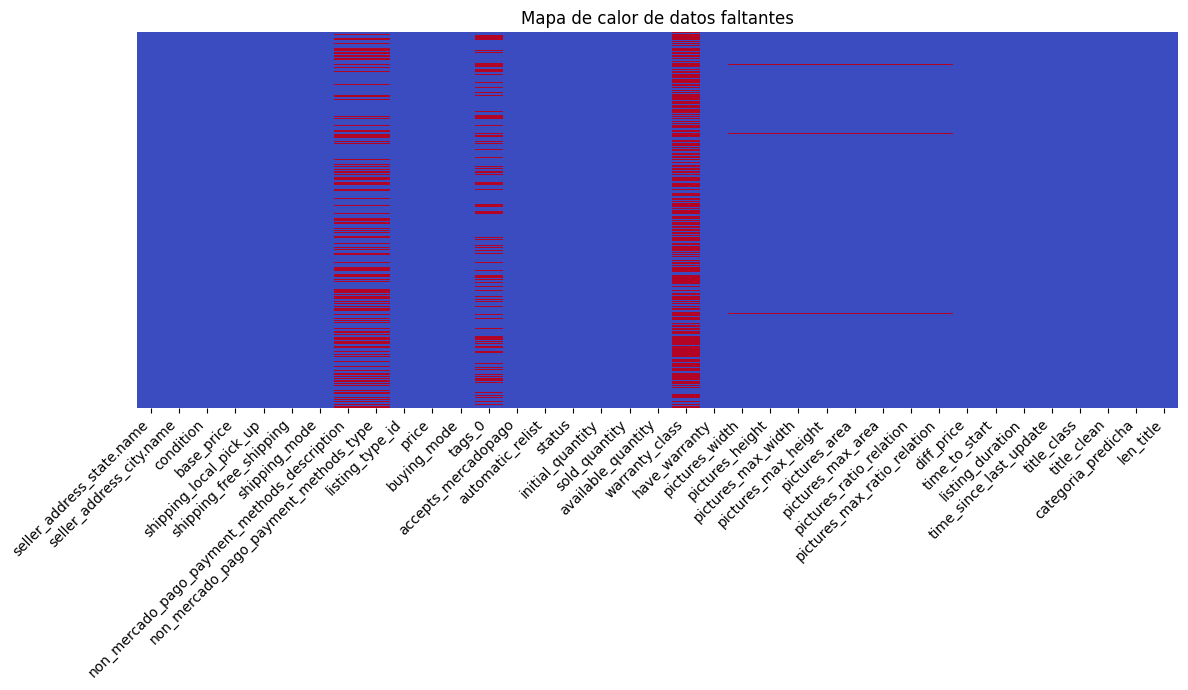

In [ ]:
def plot_missing_data(df, figsize=(10, 12)):
    """
    Genera gráficos para visualizar los datos faltantes en un dataset.

    Parámetros:
    df : pd.DataFrame
        DataFrame con los datos a analizar.
    figsize : tuple, opcional (default=(10, 12))
        Tamaño de la figura para la visualización.
    """
    missing_percentage = df.isnull().mean() * 100

    fig, axes = plt.subplots(1, 1, figsize=figsize)

    # Heatmap de valores faltantes
    sns.heatmap(df.isnull(), cmap='coolwarm', cbar=False, yticklabels=False)
    axes.set_title('Mapa de calor de datos faltantes')
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


    plt.tight_layout()
    plt.show()

plot_missing_data(df, figsize=(12, 7))

In [ ]:
missing_values = df.isnull().sum().reset_index()
missing_values.columns = ['column', 'missing_count']
missing_values = missing_values[missing_values['missing_count'] > 0]
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(df)) * 100
missing_values.sort_values(by='missing_percentage', ascending=False)

column  missing_count  \
19                                warranty_class          54757   
7   non_mercado_pago_payment_methods_description          27531   
8          non_mercado_pago_payment_methods_type          27531   
12                                        tags_0          22412   
23                            pictures_max_width            773   
24                           pictures_max_height            773   
26                             pictures_max_area            773   
28                   pictures_max_ratio_relation            773   
21                                pictures_width            703   
22                               pictures_height            703   
25                                 pictures_area            703   
27                       pictures_ratio_relation            703   
1                       seller_address_city.name              2   
0                      seller_address_state.name              1   

    missing_percentage  
19           60.841111  
7            30.590000  
8            30.590000  
12           24.902222  
23            0.858889  
24            0.858889  
26            0.858889  
28            0.858889  
21            0.781111  
22            0.781111  
25            0.781111  
27            0.781111  
1             0.002222  
0             0.001111

**Datos faltante:**
* **warranty [60%]:** la variable con mayor cantidad de datos faltantes es 'warranty_class', para este caso el no tener información es igual a 'sin garantia' por lo tanto imputaremos por este valor
* **non_mercado_pago_payment_methods_description [30%]:** en este caso imputaremos por la moda, es decir que el pago sea en 'efectivo'
* **non_mercado_pago_payment_methods_type [30%]:** dada la cantidad de datos faltantes igualmente imputaremos por la moda
* **tags_0 [24%]:**: dada la cantidad de datos faltantes igual, imputaremos por la moda 'dragged_bids_and_visits'.
* **other features < 10% :** se imputaran por la mediana debido a que pueden presentar distribución sesgada. 'se comprobara más adelante'

### 5.2 Grafico para variables categoricas bi variado

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


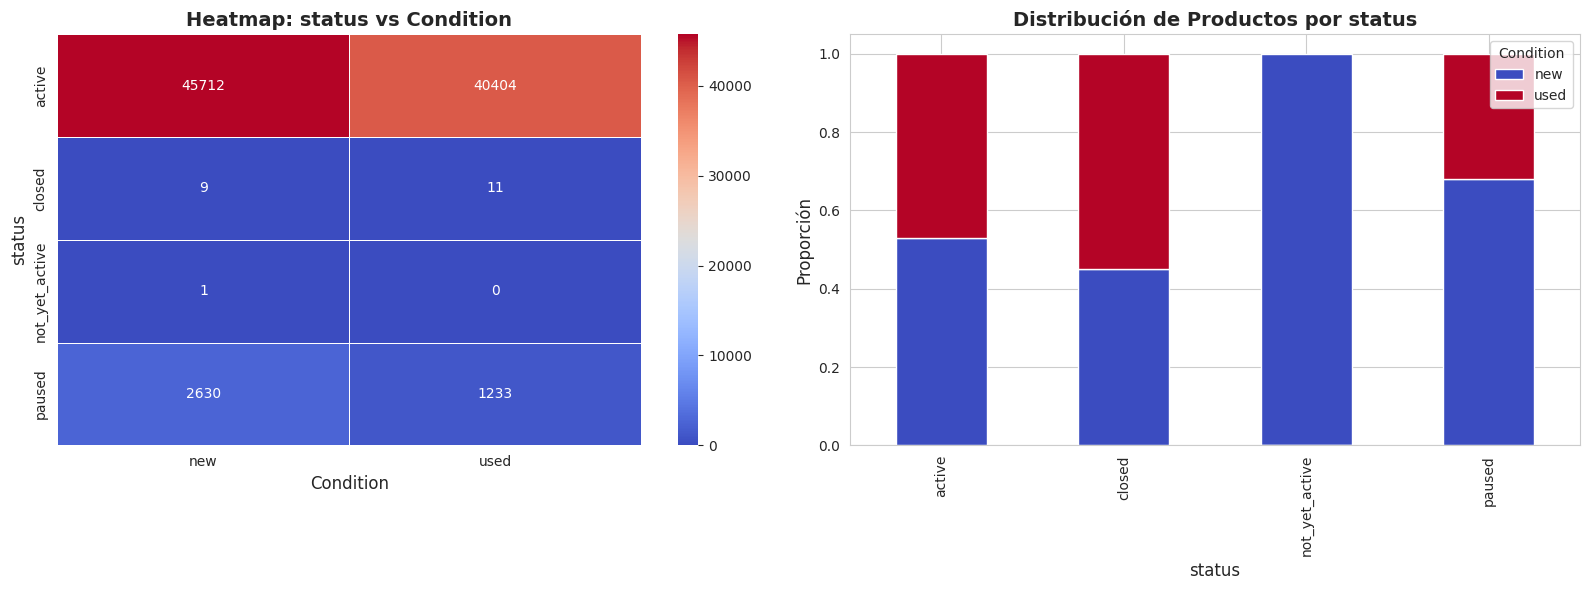

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


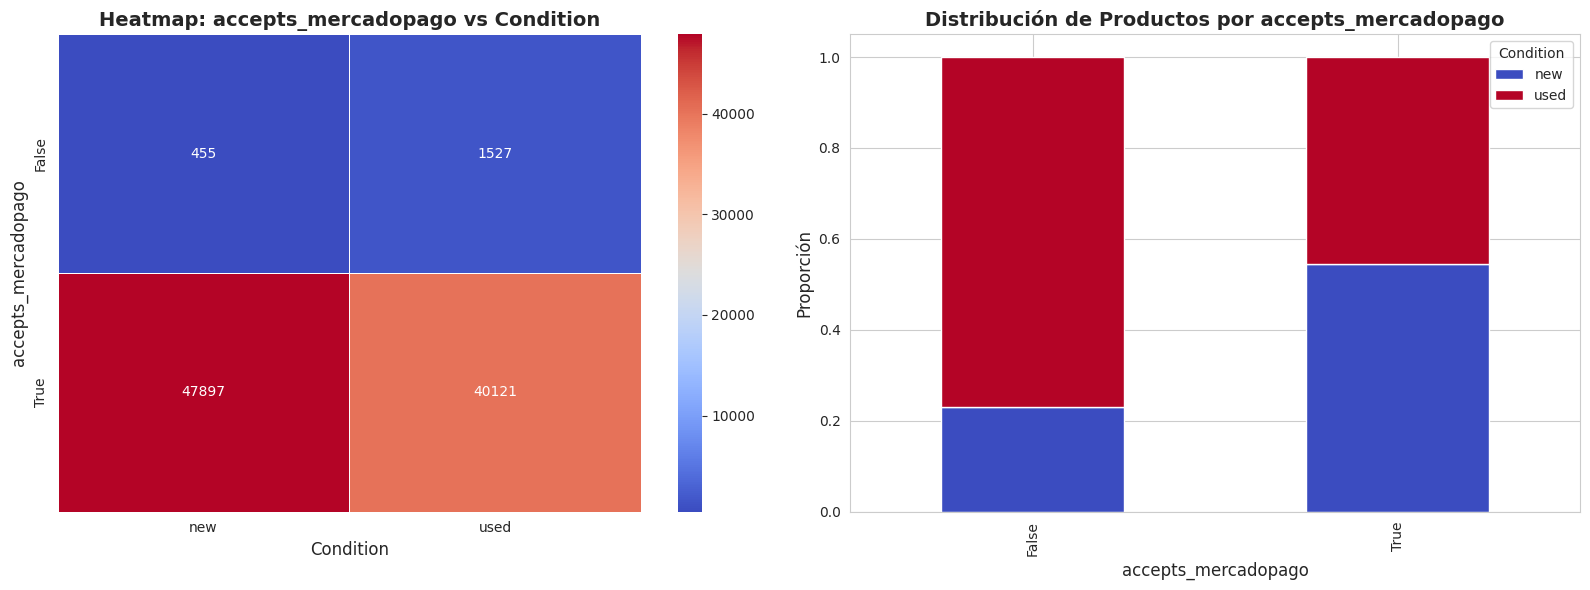

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


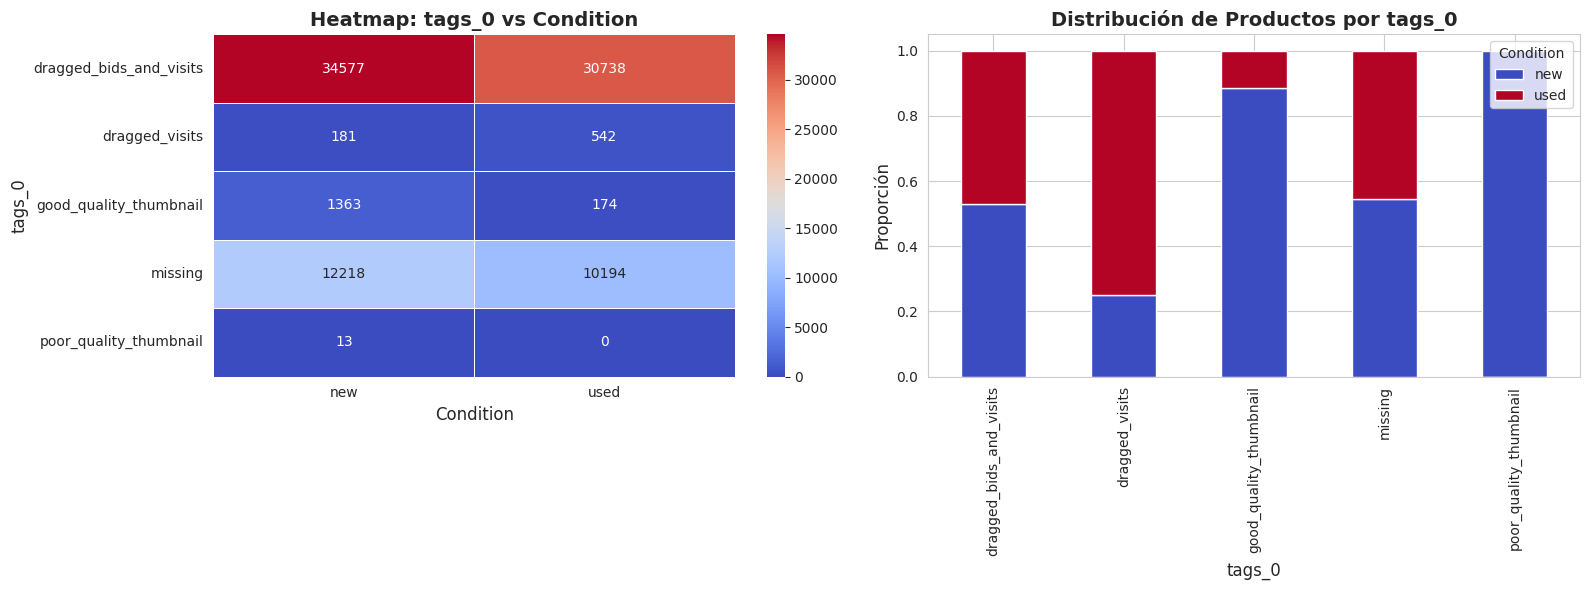

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


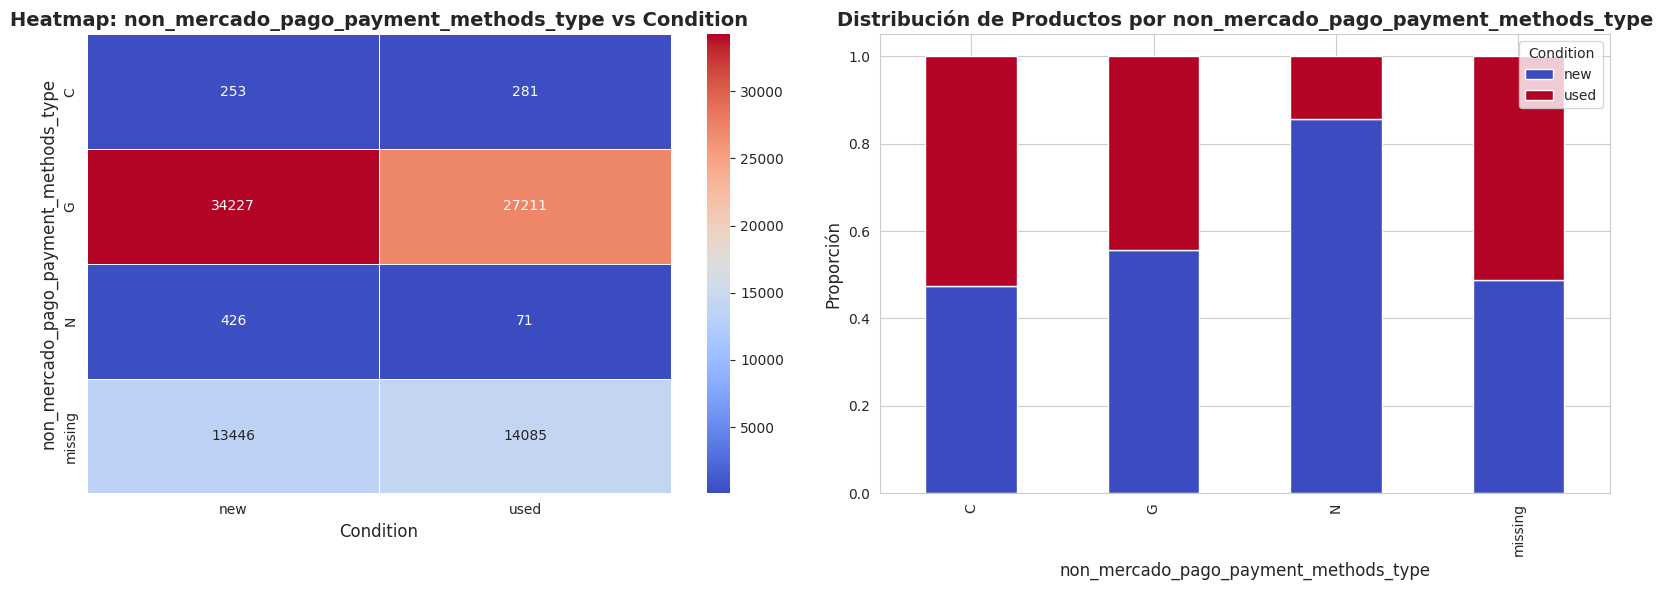

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


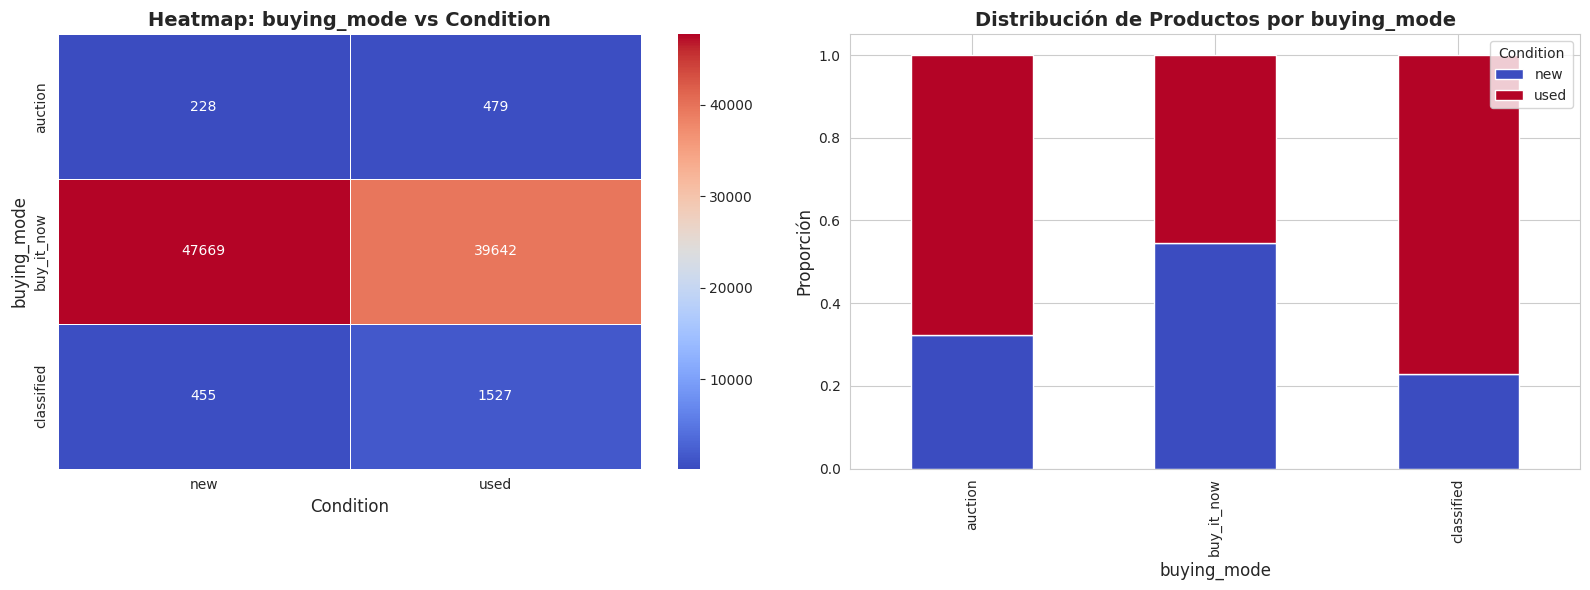

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


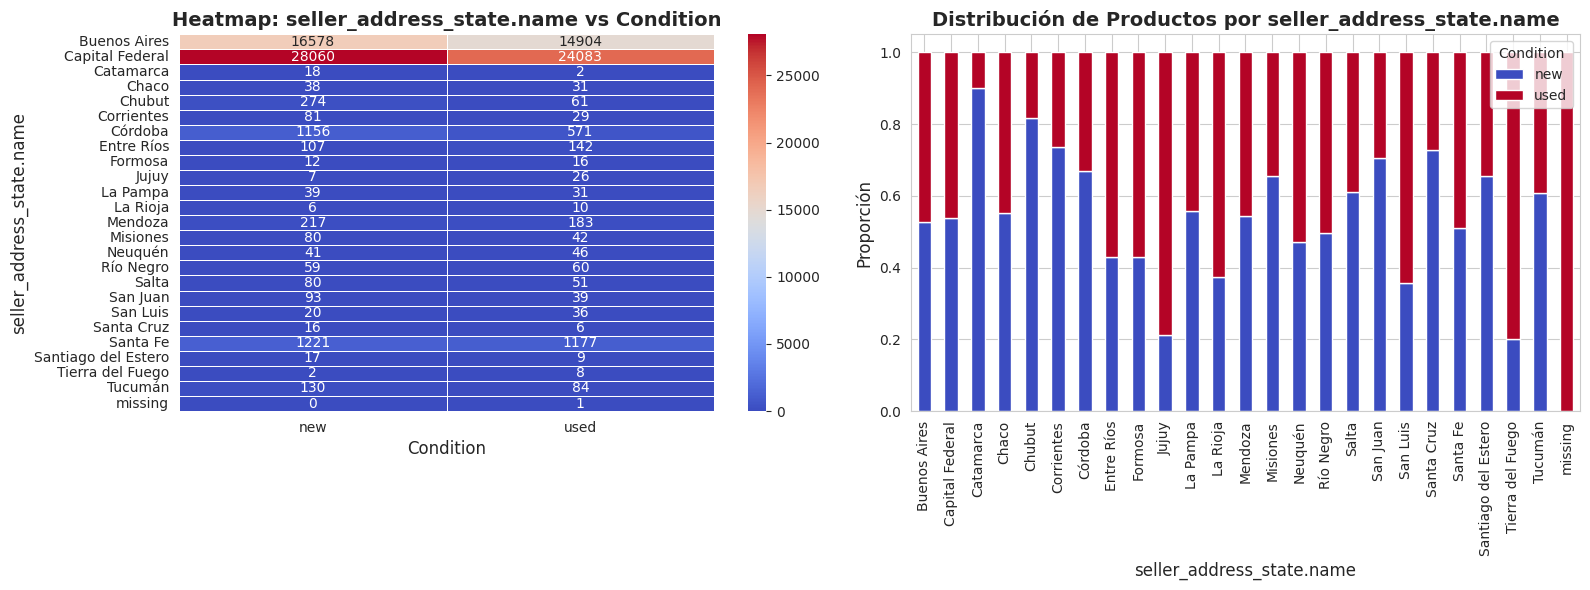

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


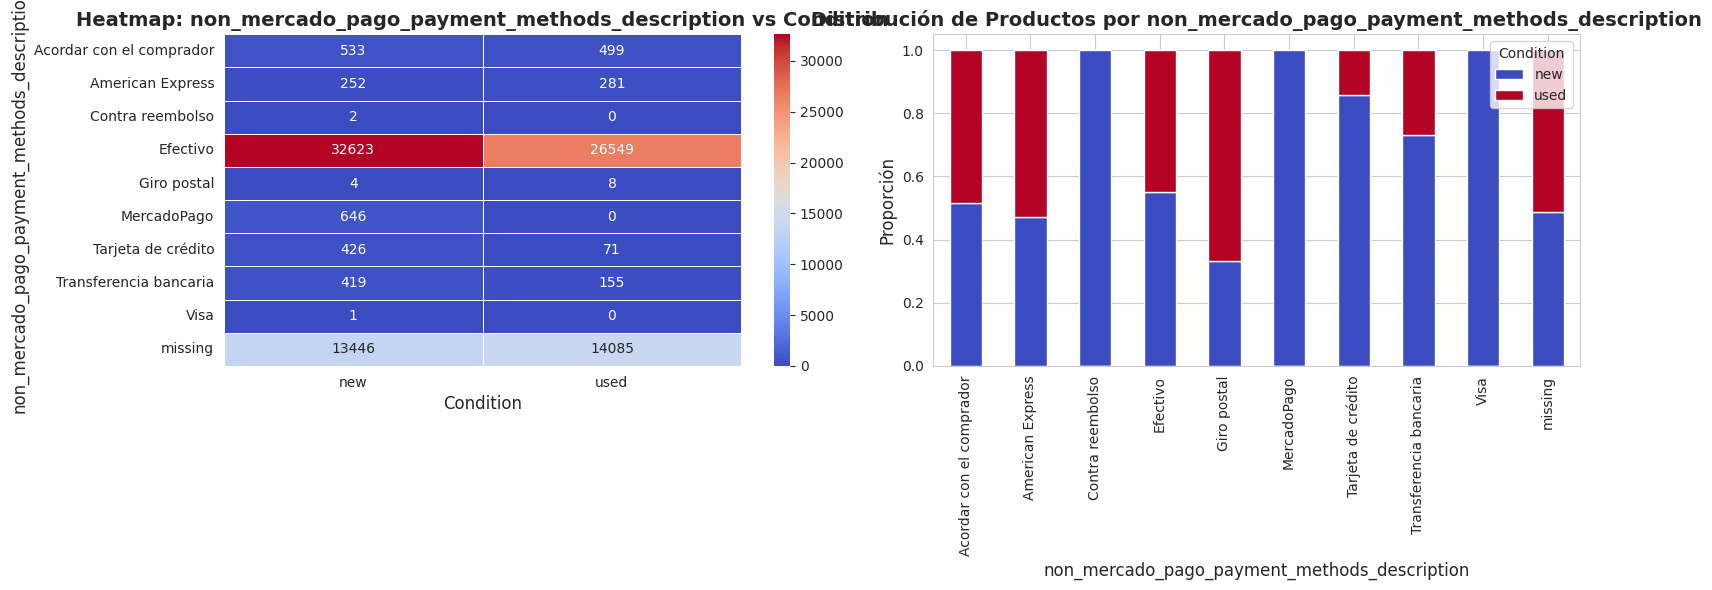

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


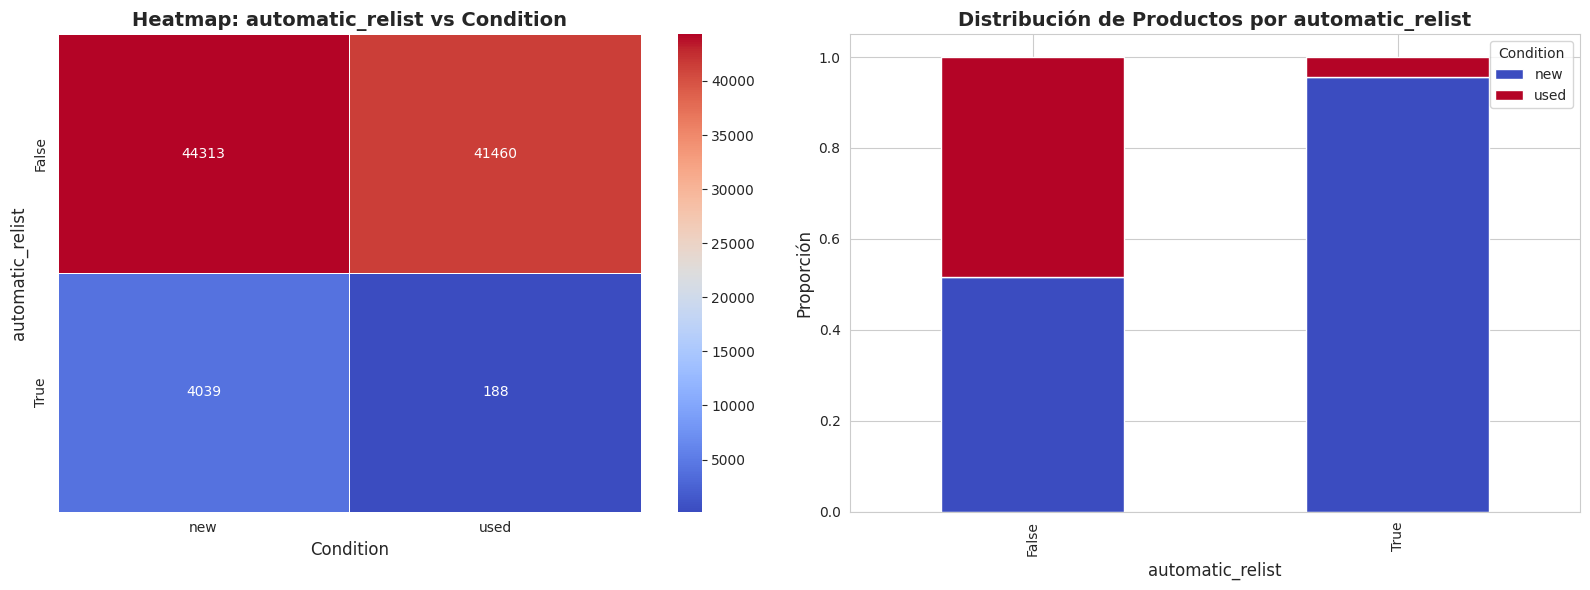

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


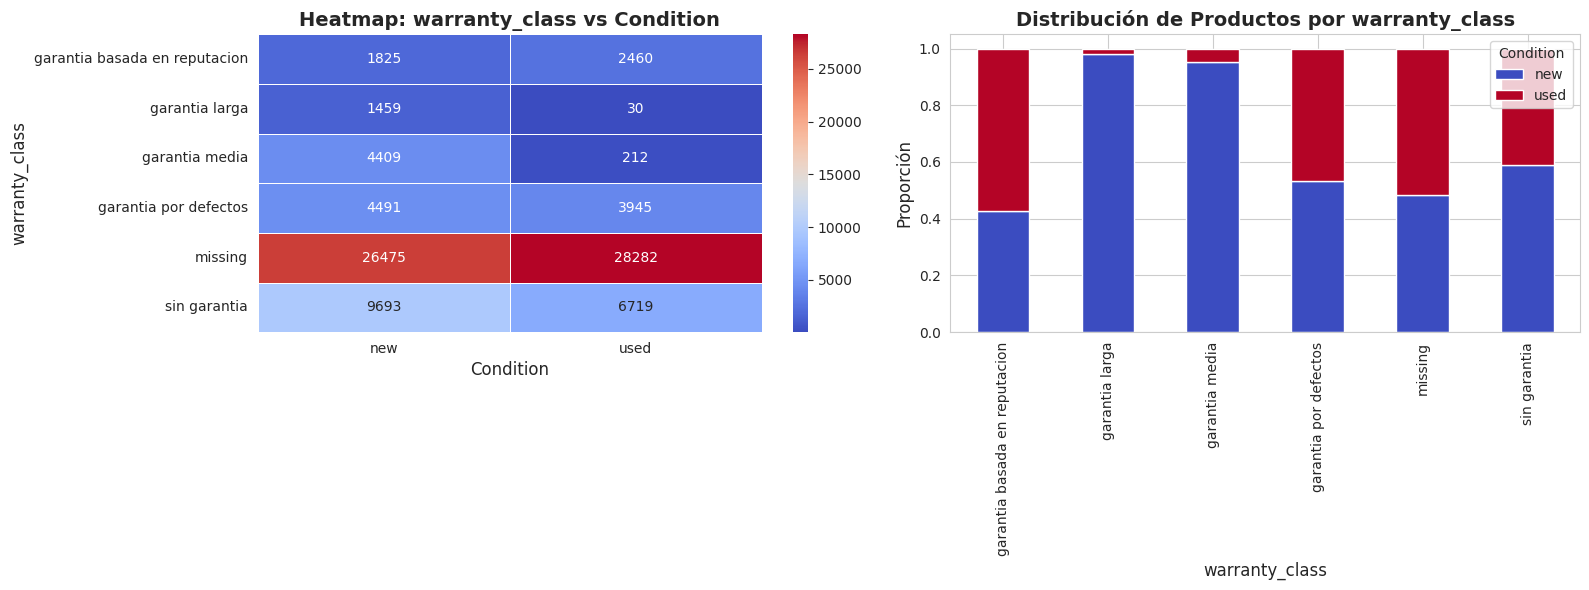

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


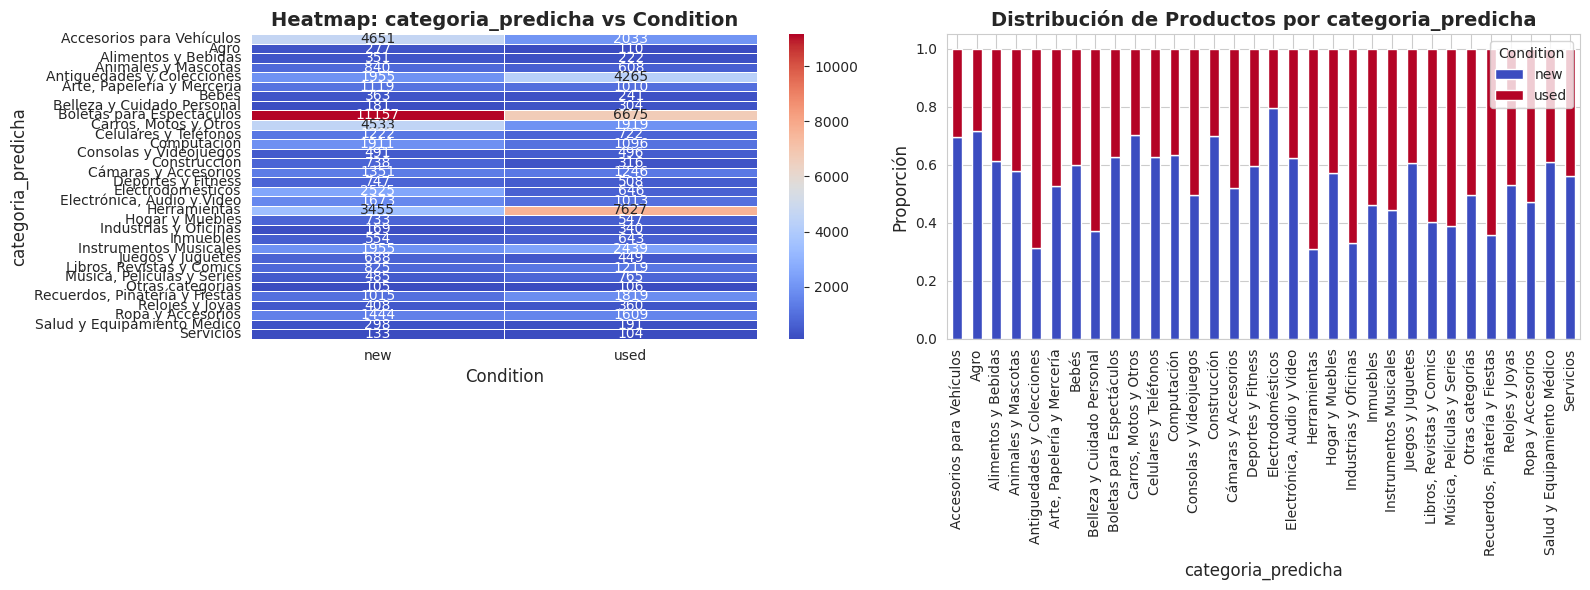

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


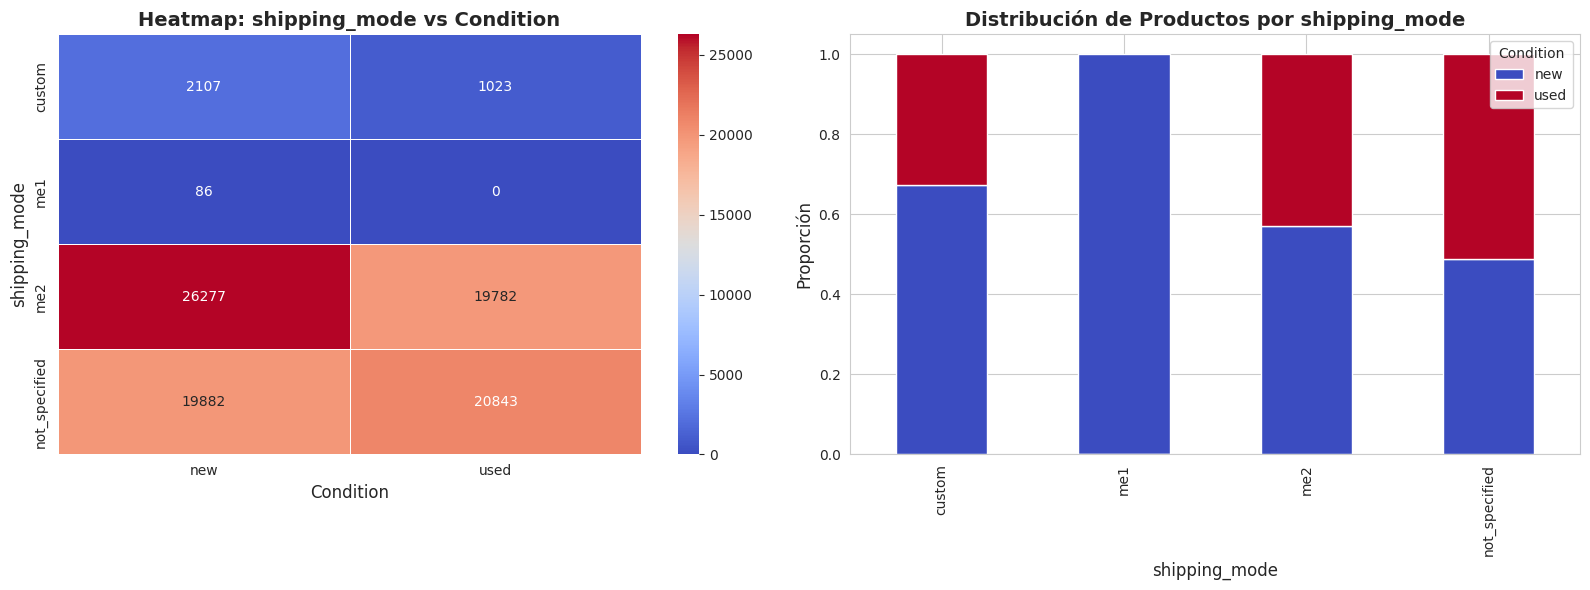

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


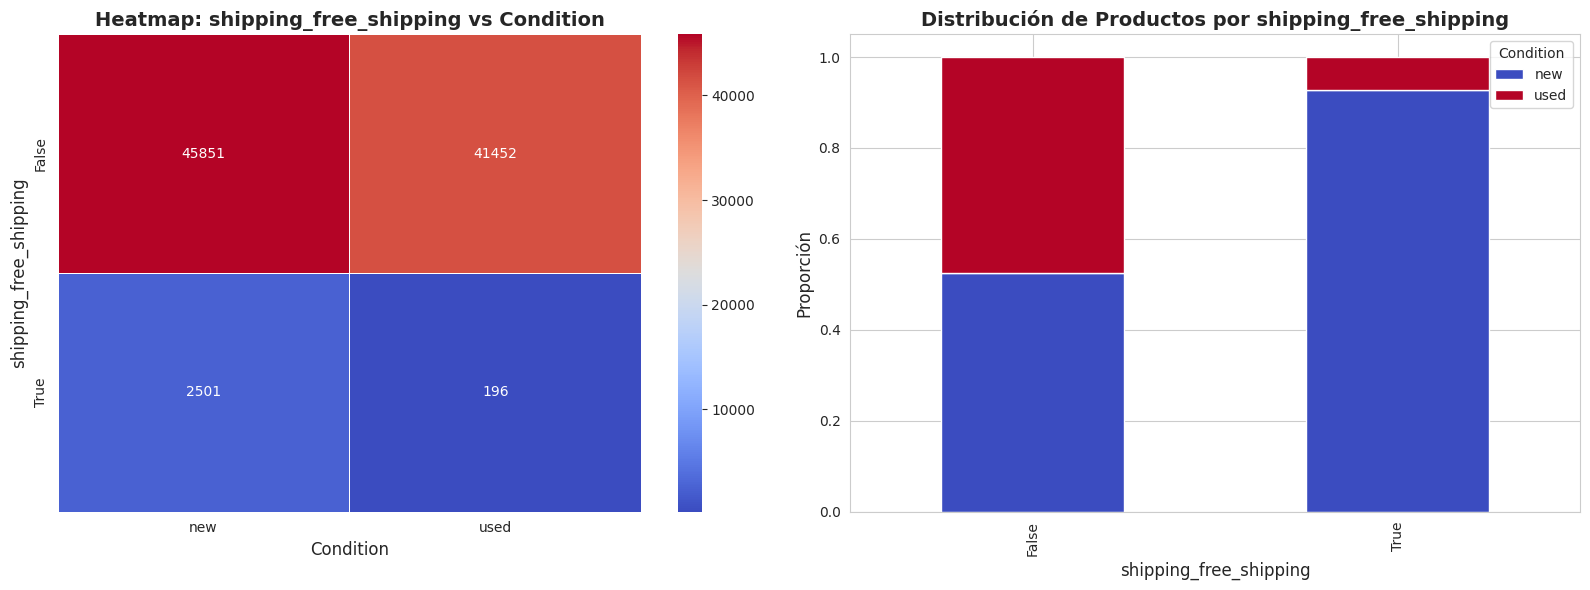

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


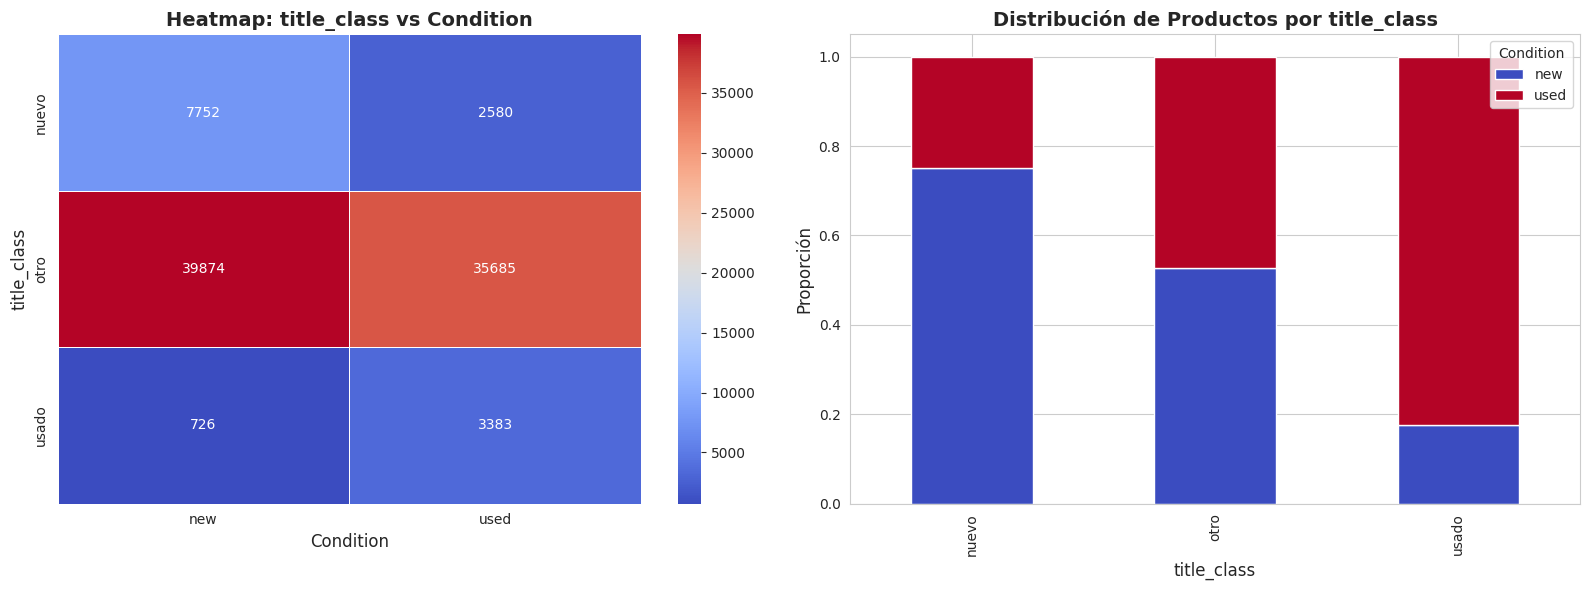

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


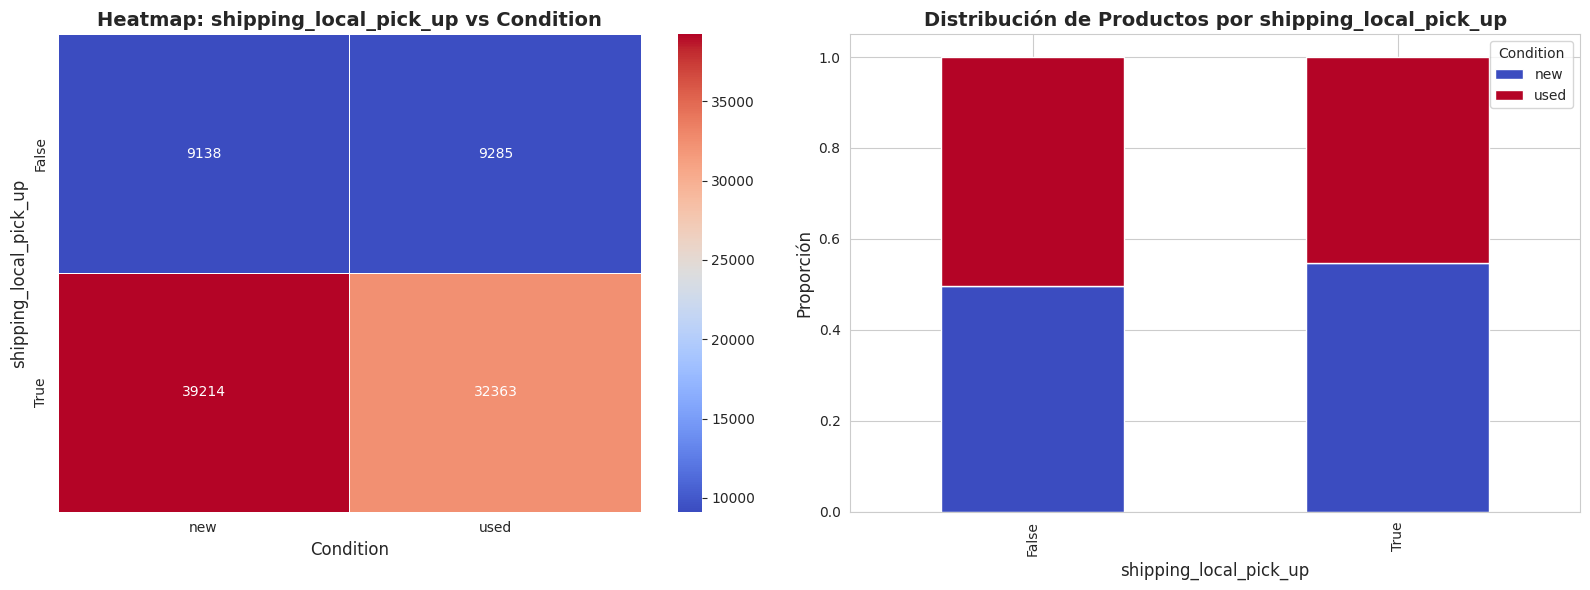

<ipython-input-73-eb099719900b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[categorical_col].fillna('missing', inplace=True)


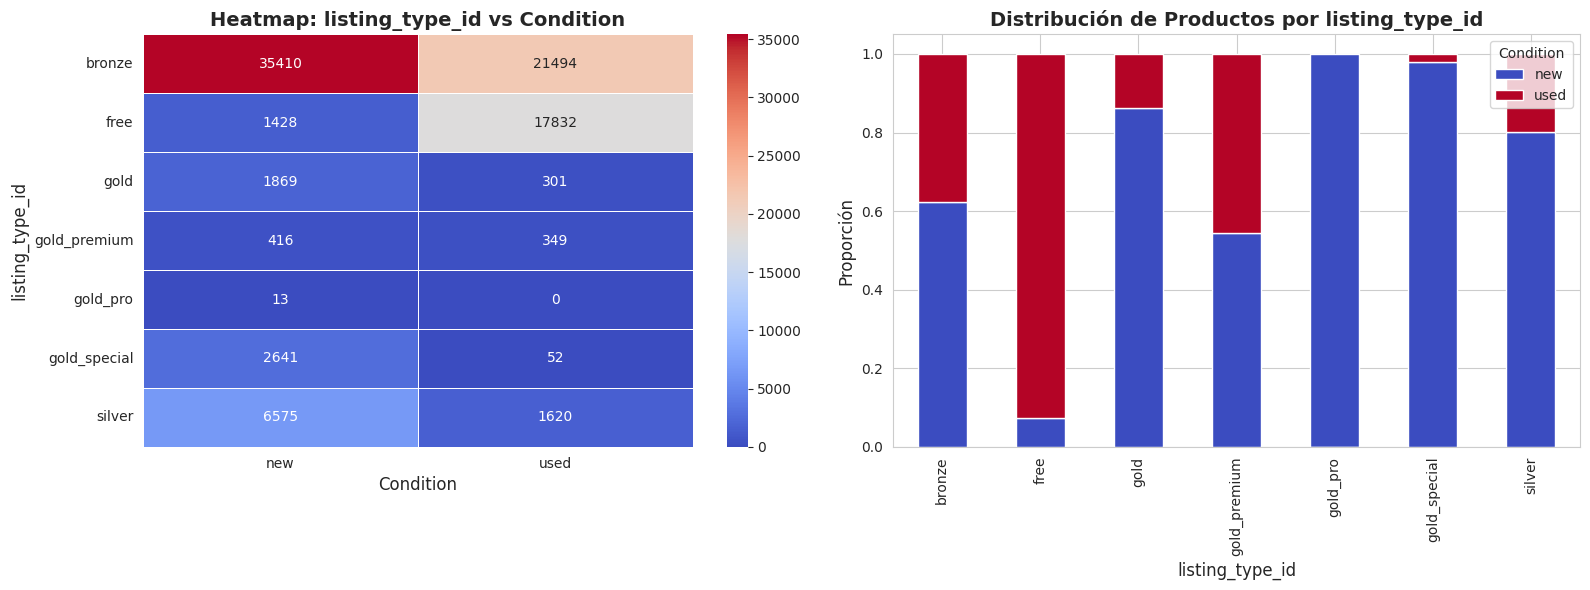

In [ ]:
def plot_categorical_vs_condition(df, categorical_col):
    """
    Genera un heatmap y un gráfico de barras apiladas para analizar la relación entre
    una variable categórica y la condición del producto (nuevo/usado).

    Parámetros:
    - df: DataFrame con la variable categórica y la columna 'condition'.
    - categorical_col: Nombre de la columna categórica a analizar.
    """
    # Verificar que las columnas existen en el DataFrame
    if categorical_col not in df.columns or 'condition' not in df.columns:
        raise ValueError("Las columnas especificadas no existen en el DataFrame.")

    # Filtrar valores nulos en la variable categórica
    df_filtered = df[[categorical_col, 'condition']].copy()
    df_filtered[categorical_col].fillna('missing', inplace=True)

    # Crear tabla de frecuencias
    category_condition_counts = df_filtered.groupby([categorical_col, "condition"]).size().unstack()

    # Configurar figura
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Heatmap: Relación entre la variable categórica y la condición del producto
    sns.heatmap(category_condition_counts.fillna(0).astype(int),  # Asegurar valores enteros
                annot=True, cmap="coolwarm", fmt="d", linewidths=0.5, ax=ax[0])
    ax[0].set_title(f"Heatmap: {categorical_col} vs Condition", fontsize=14, fontweight="bold")
    ax[0].set_xlabel("Condition")
    ax[0].set_ylabel(categorical_col)

    # Gráfico de Barras Apiladas: Proporción de Nuevos vs Usados por categoría
    category_condition_counts_norm = category_condition_counts.div(category_condition_counts.sum(axis=1), axis=0)
    category_condition_counts_norm.plot(kind="bar", stacked=True, colormap="coolwarm", ax=ax[1])
    ax[1].set_title(f"Distribución de Productos por {categorical_col}", fontsize=14, fontweight="bold")
    ax[1].set_xlabel(categorical_col)
    ax[1].set_ylabel("Proporción")
    ax[1].legend(title="Condition", loc="upper right")

    # Mostrar gráficos
    plt.tight_layout()
    plt.show()

for col in type_feature['categorical']:
    plot_categorical_vs_condition(df, col)

**Variables categoricas:**
* **status:** se encuentra fuertemente desbalanceada hacia 'active' no se logra distinguir alguna diferencia clara entre productos nuevo/usado. se transormara de manera binaria donde 1 es active y 0 no active

* **accepts_mercadopago:** la mayor cantidad de productos aceptan mercado pago sin distinción clara entre productos nuevo/usado

* **tags_0:** los productos 'new' suelen tener alguna clasificación de 'quality_thumbnail' ya sea buena o mala. la mayoría de productos tuvieron interacciones y visitas tanto nuevos como usados, se tienen algunos valores faltantes sin distinción. pueden ser productos que no llegaron a visualizarse

* **non_mercado_pago_payment_methods_type:** los productos marcados como 'N' suelen ser en su mayoría nuevos. en la demás categorías la proporción es igual

* **buying_mode:** los productos que predominan son los marcados como 'buy_it_now', más del 95% y no existe distinción clara entre productos nuevo/usado

* **seller_address_state.name:** se observa que predomina 'Buenos aires' y 'Capital Federal' los cuales hacen referencia al mismo lugar. por lo tanto se homologara a 'CABA', vemos que en ese lugar se concentra la mayor cantidad de comercio de la región o de los productos ya que abarcan aprox 90% de los productos y no se ve una distinción de productos nuevo/usado, ya en los demás lugares vemos tendencias de compra hacia productos nuevos en algunos lugares y a usados en otros. sin embargo al ser tan poco representativos en la muestra pueden no ser significativos estos comportamientos. se agruparan categorías para disminuir cardinalidad donde quedaran 'CABA', 'Córdoba', 'Santa Fe' y Otros'

* **non_mercado_pago_payment_methods_description:** vemos que en su mayoría de productos se acepta el pago de efectivo mayormente para productos nuevos. vemos que MercadoPago solo lo aceptan productos nuevos. se agruparan categorías para disminuir cardinalidad donde quedaran 'Efectivo', 'MercadoPago', 'Otros'

* **automatic_relist:** variable bool en su mayoría como False, es decir, la mayor cantidad de productos no tienen relanzamiento automático. aquellos que tienen actívate el relanzamiento automático tienen 96% de probabilidad de ser nuevos

* **warranty_class:** los productos clasificados con garantía larga y media tienen probabilidad del 96% de ser nuevos, las demás categorías no presentan distinción. se tienen mas del 60% de valores faltantes se asume que no deben tener garantía

* **categoria_predicha:** Esta variable se creo con la taxonomía oficial de MercadoLibre tomando las categorías principales del nivel 1 a partir de clasificación de embeddings de los títulos de los productos. vemos que para cada categoría predomina una inclinación hacia productos nuevos y otras hacia productos usados. en donde con mayor participación y diferencia predominan 'boletas_para_espectaculos', 'herramientas' y 'carros y motos'

* **shipping_mode:** vemos que los productos que ofertan 'me1' son solo nuevos. ya los demás prefieren el método 'me2' sin diferencia entre productos nuevo/usado

* **shipping_free_shipping:** los productos que tienen envió gratis con 95% de probabilidad son nuevos. más del 94% de los productos no tienen envió gratis.

* **title_class:** en esta clasificación de productos, los productos clasificados como 'nuevos' y como 'usado'
 tienen un probabilidad cercana al 80% de serlo. aproximadamente el para el 78% de los productos no se les pudo definir una categoría por medio de palabras clave en el titulo de sus productos.

* **shipping_local_pick_up:** esta variable en su mayoría si permite la recogida en tienda. sin embargo no presenta diferencias entre productos nuevo/usado

* **listing_type_id:** en estas categorías de visualización de productos se observa que los productos publicitados free tienen el 92% de probabilidad de ser usados. para los productos nuevos prefieren modos como 'gold', 'gold_pro' y 'gold_special'. la categoría silver suelen usarla más en productos nuevos

### 5.3 Grafico para variables numericas bi variado

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


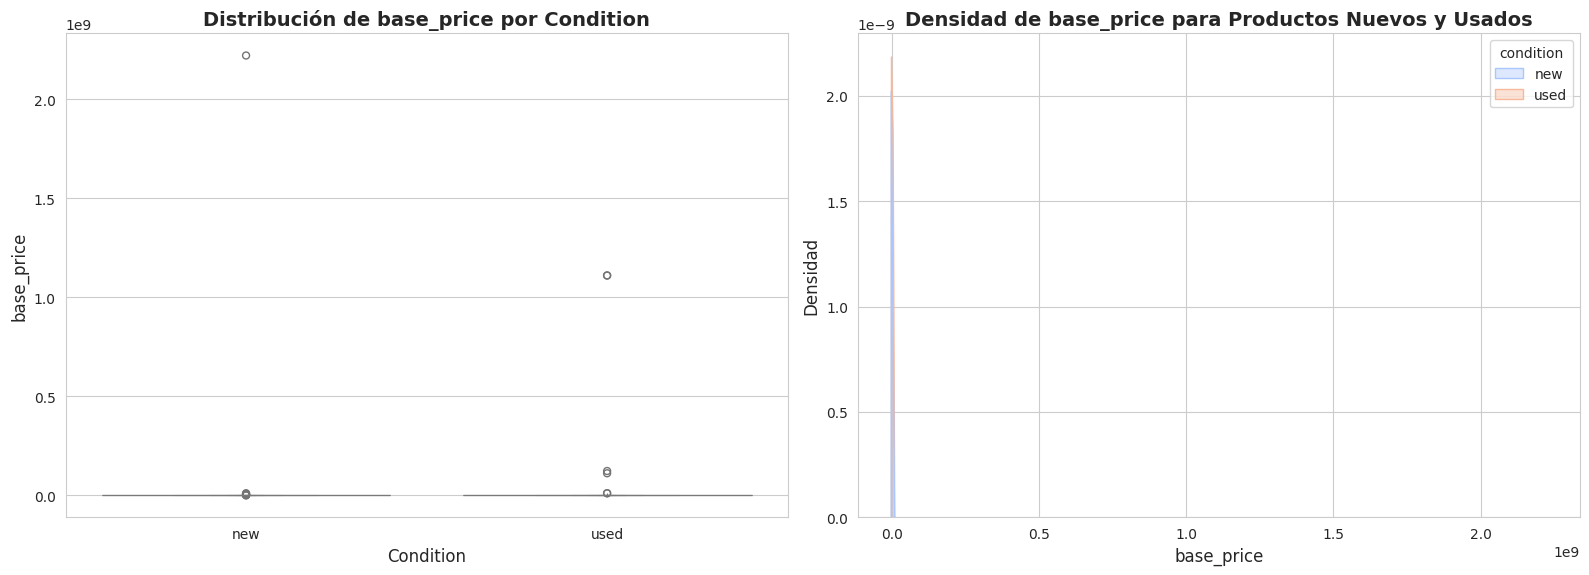

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


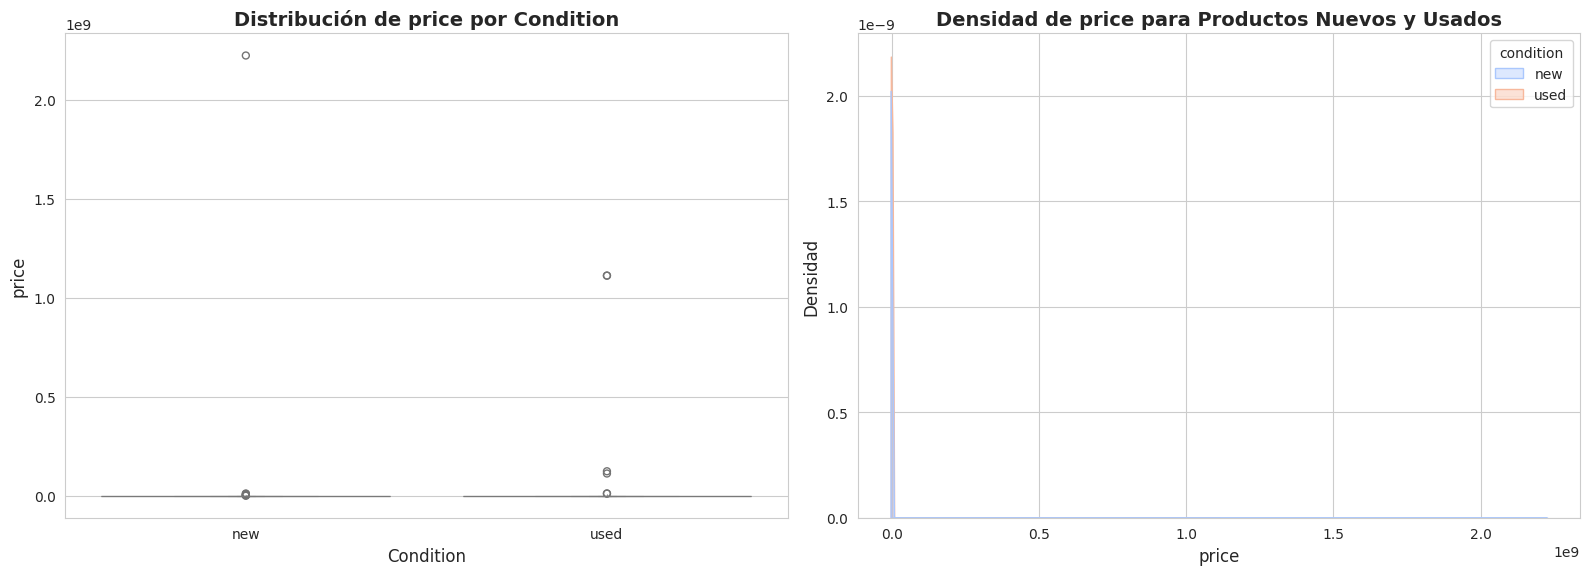

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


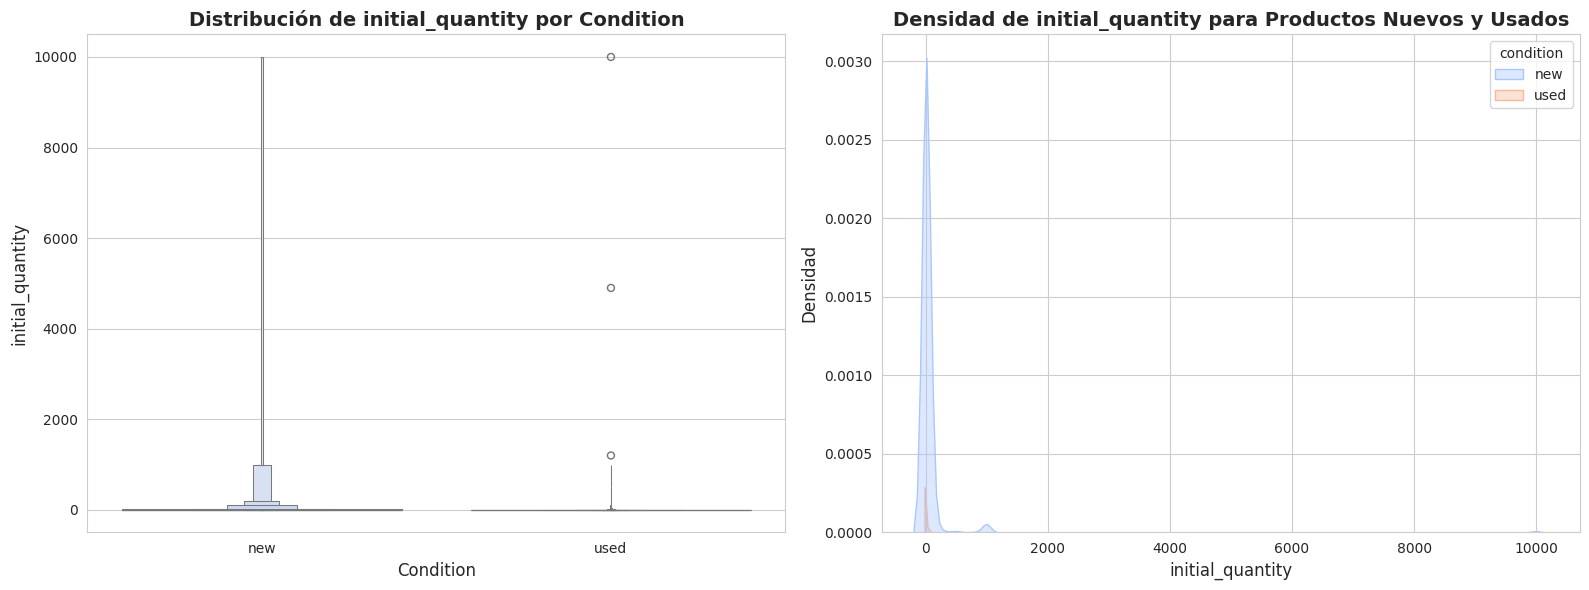

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


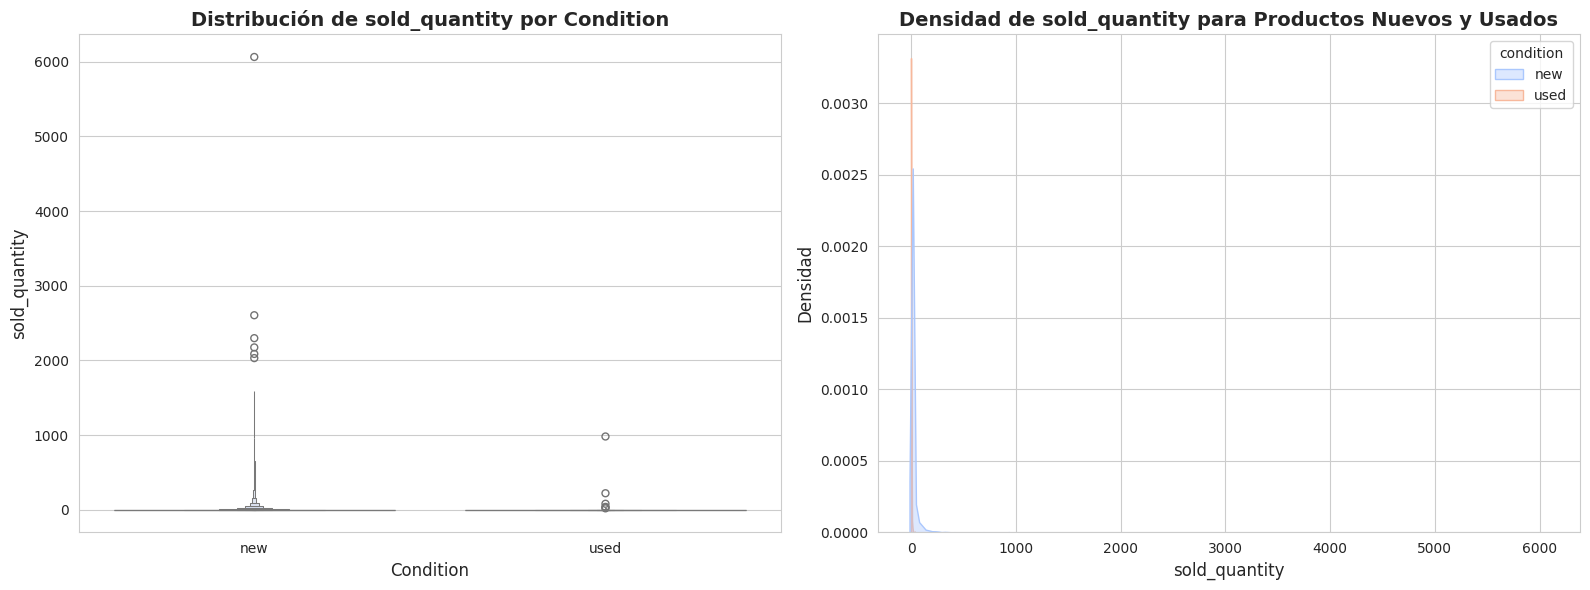

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


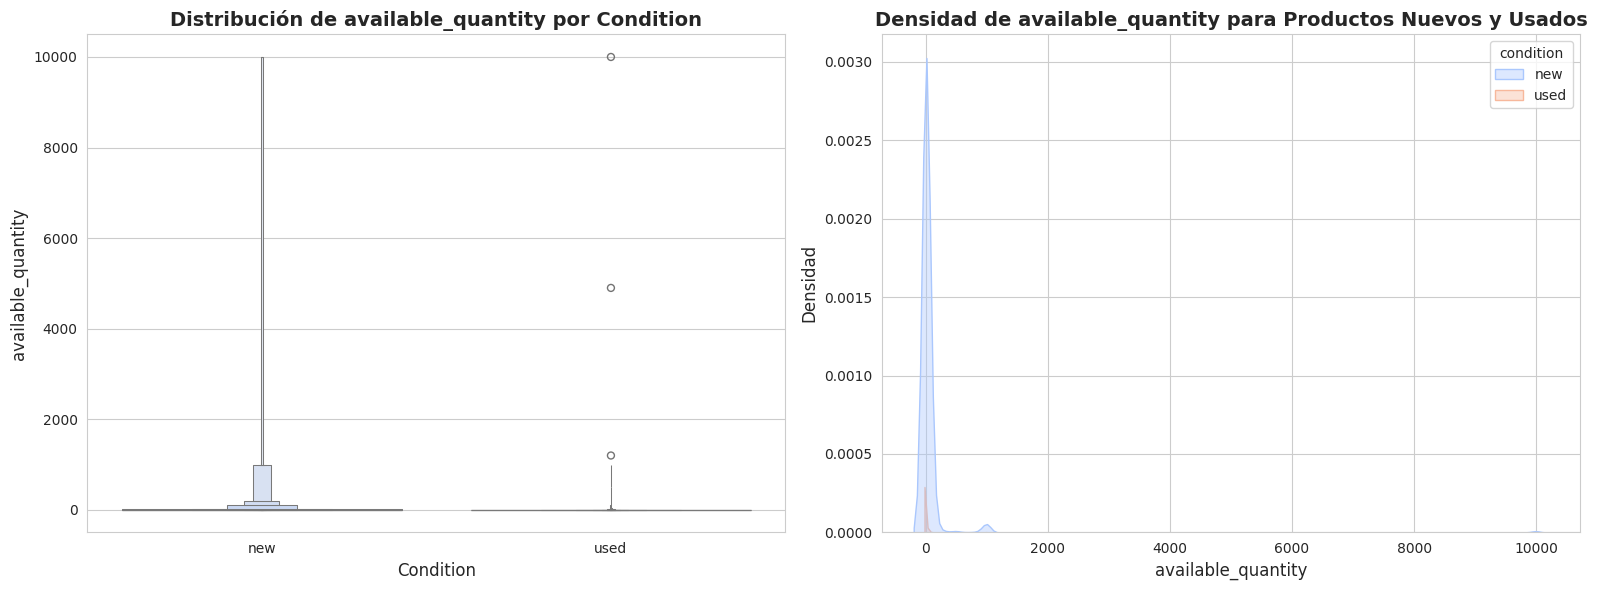

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


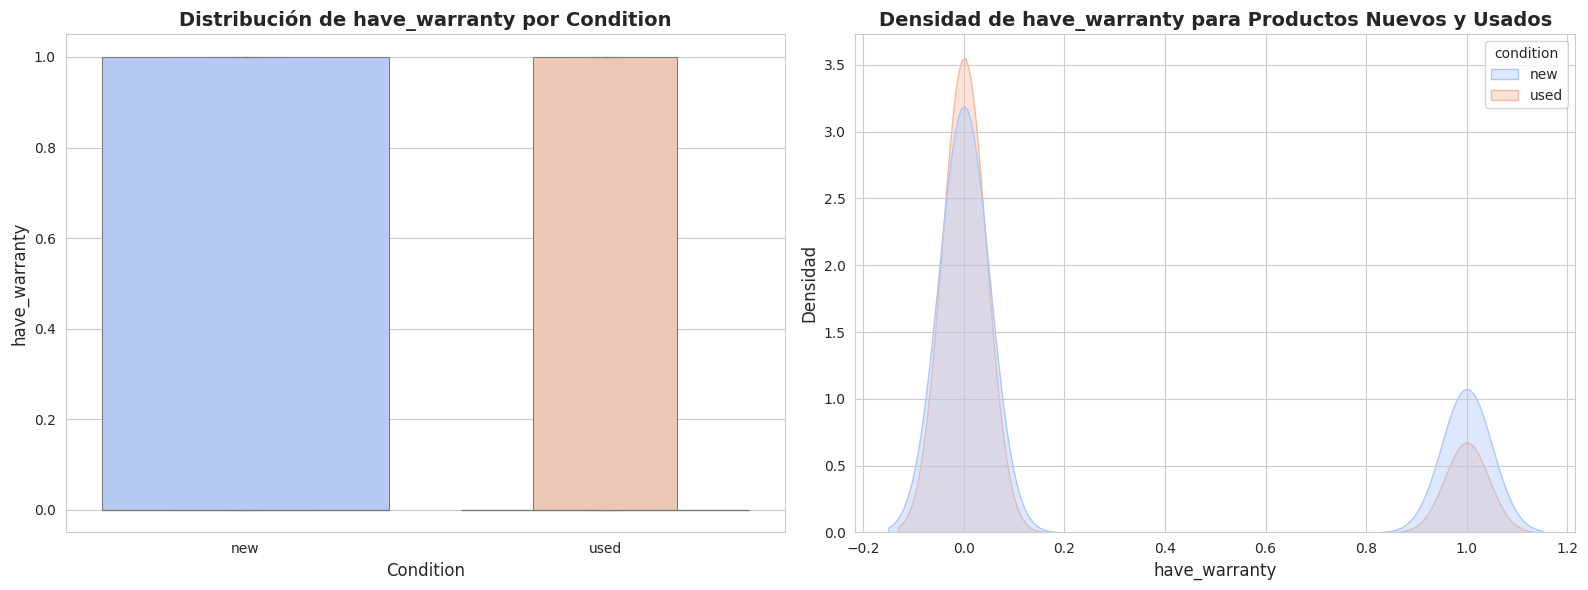

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


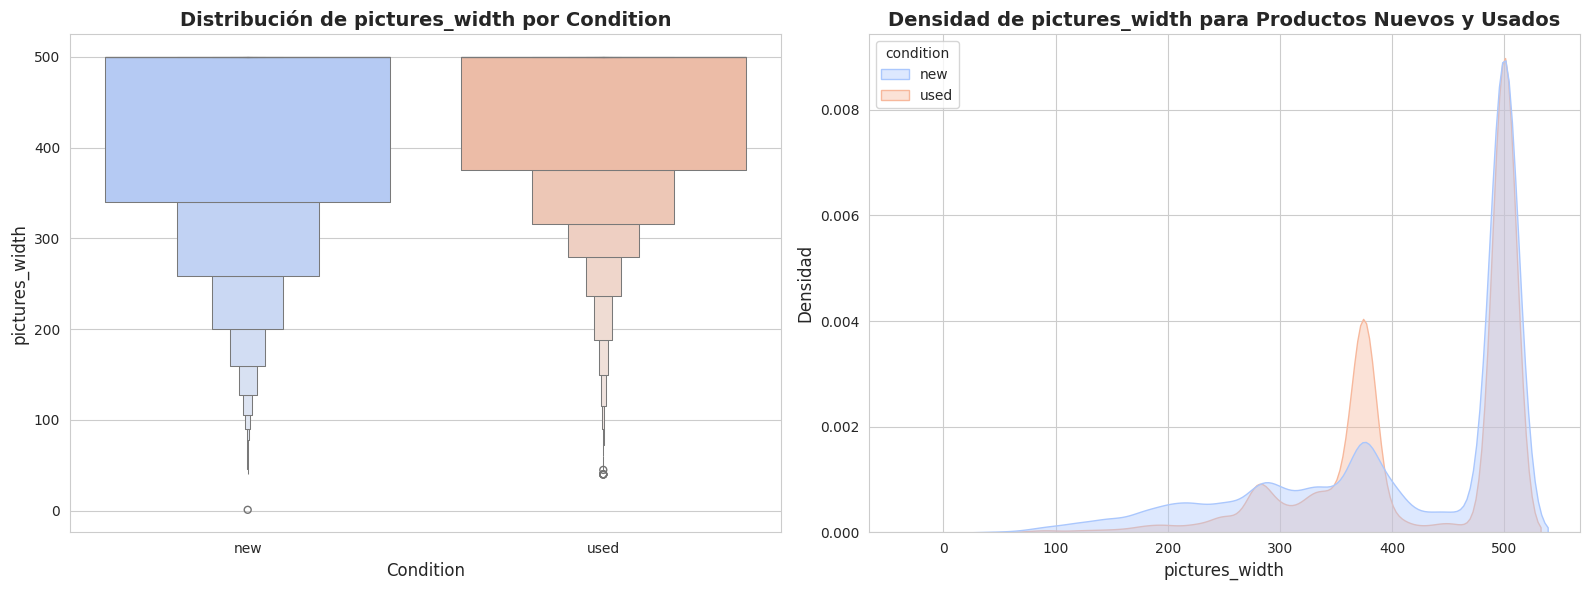

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


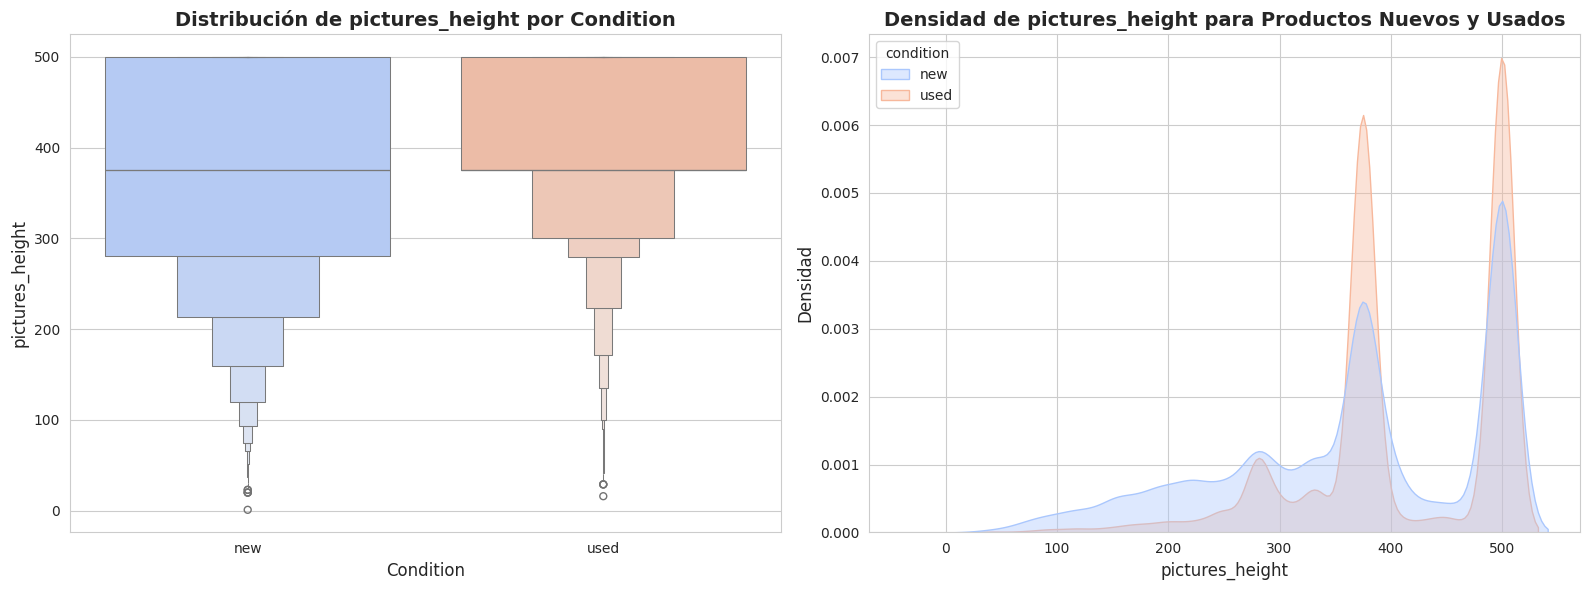

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


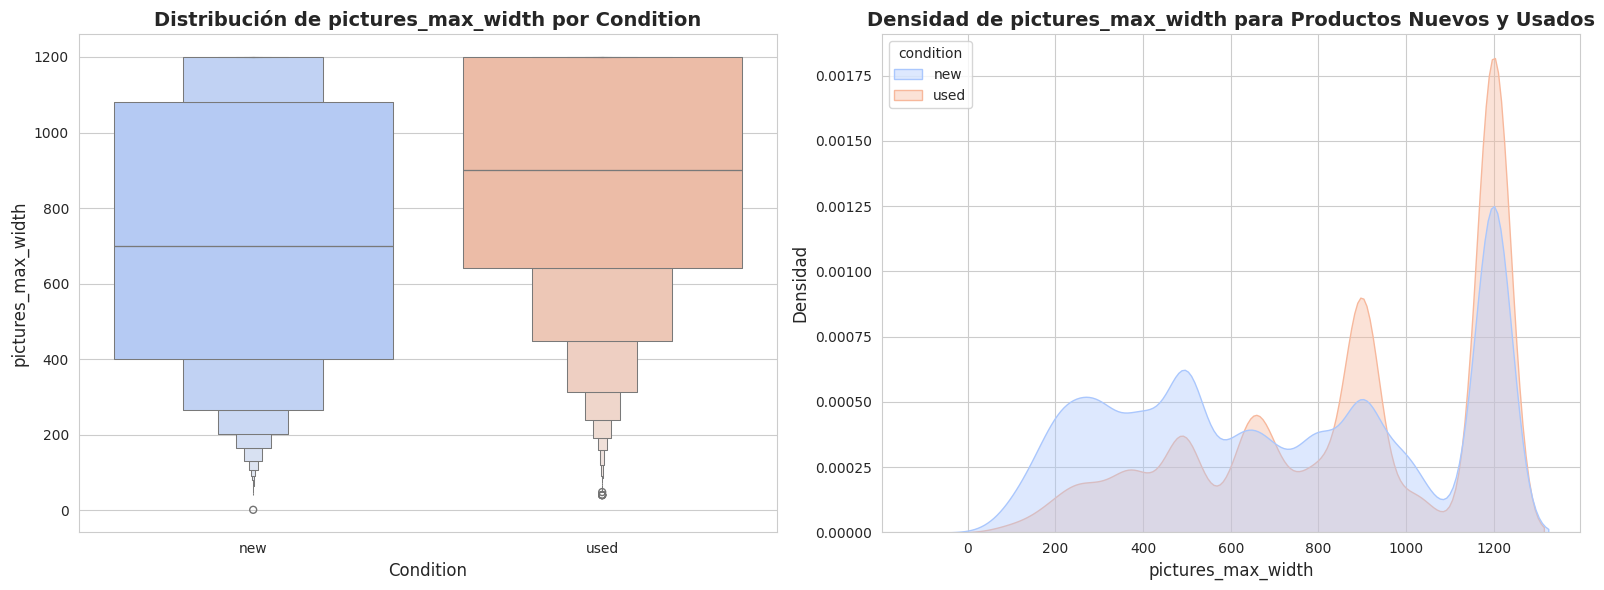

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


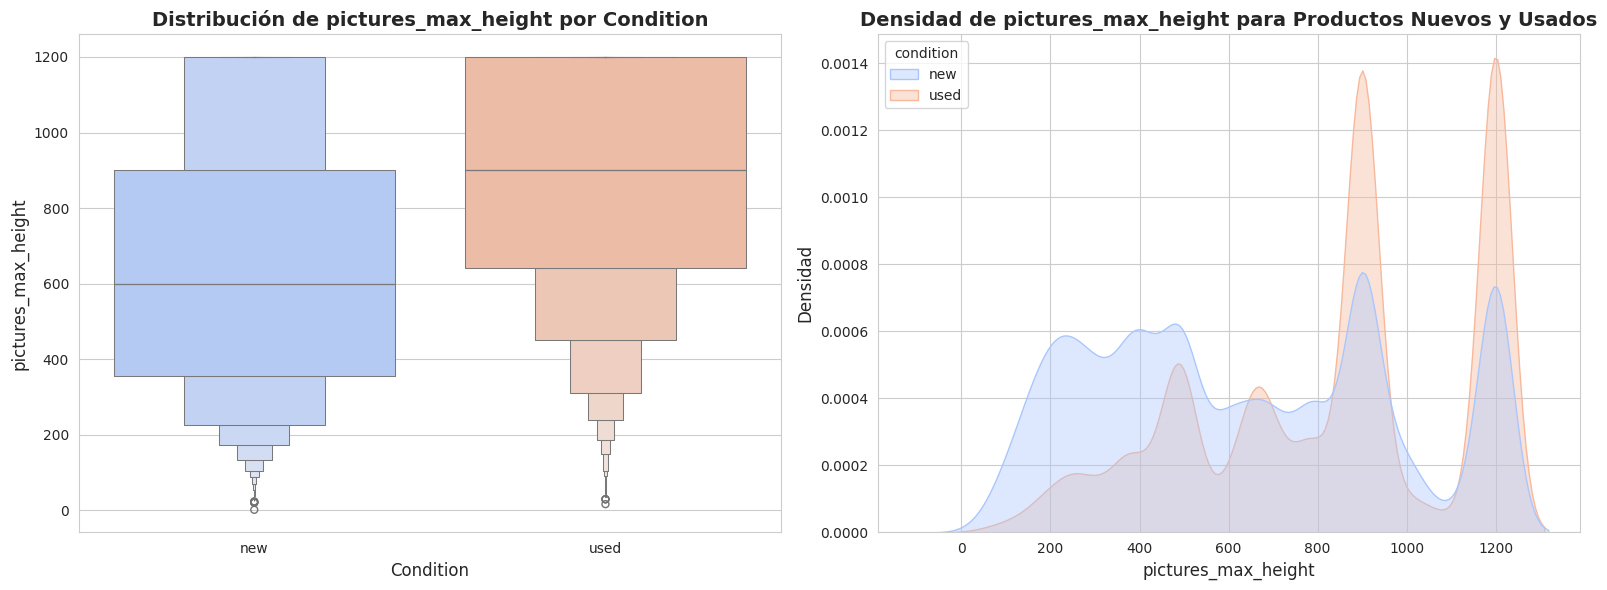

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


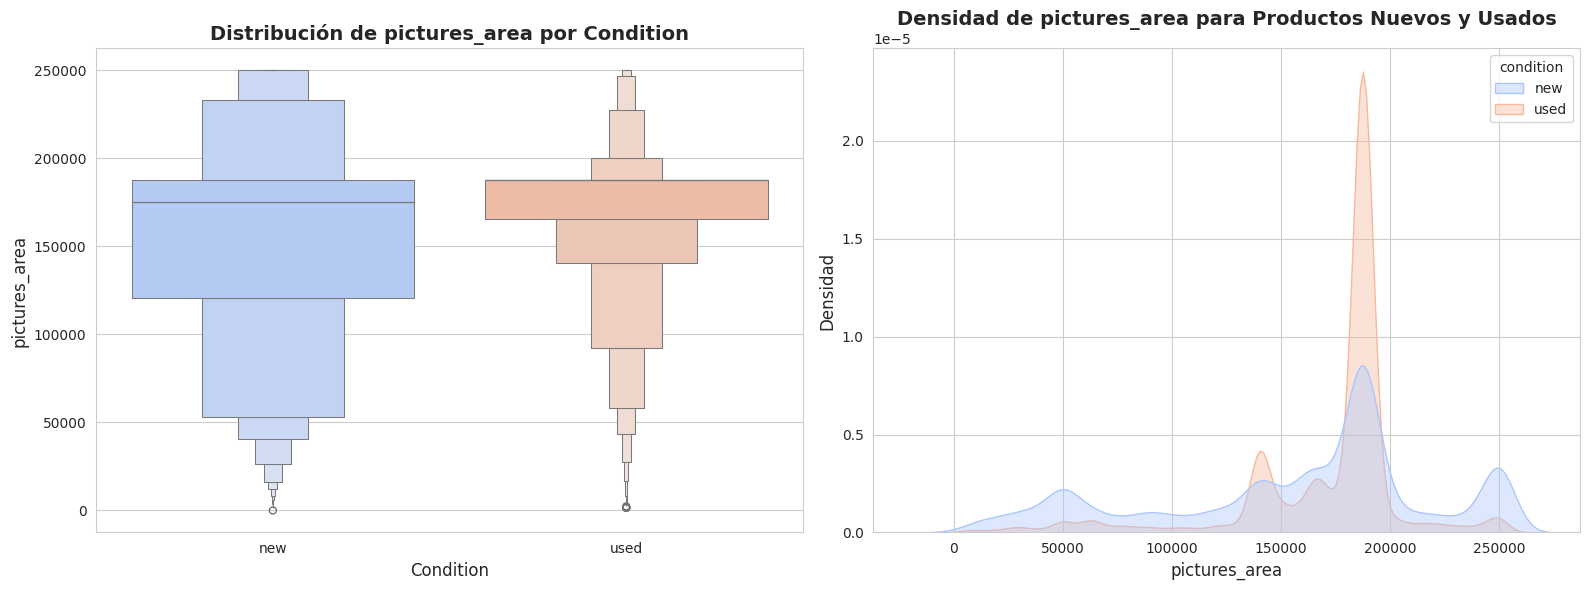

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


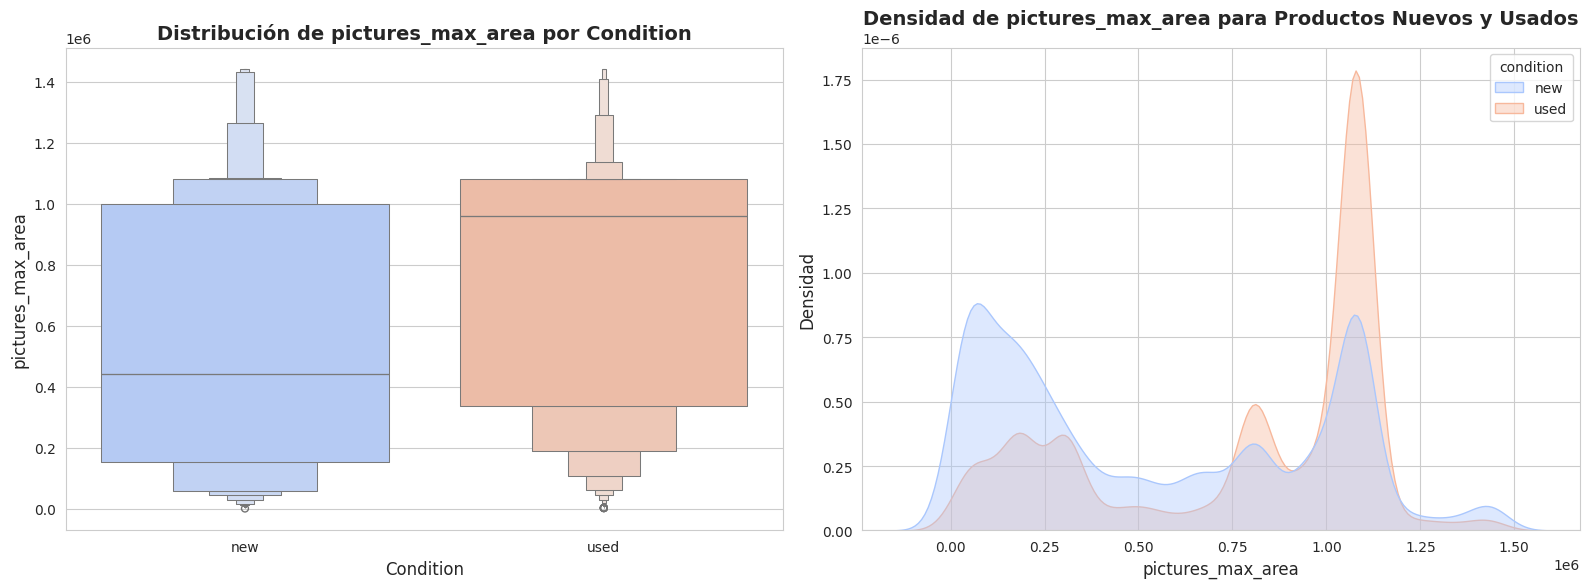

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


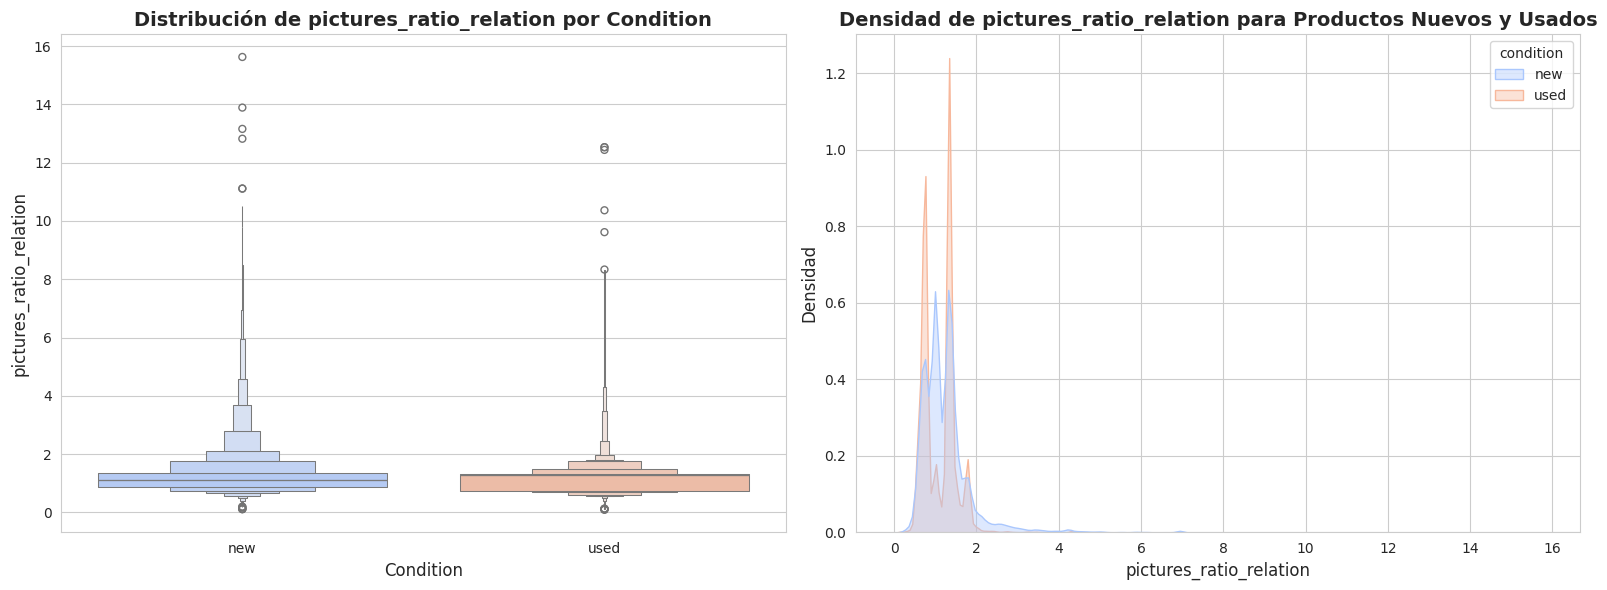

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


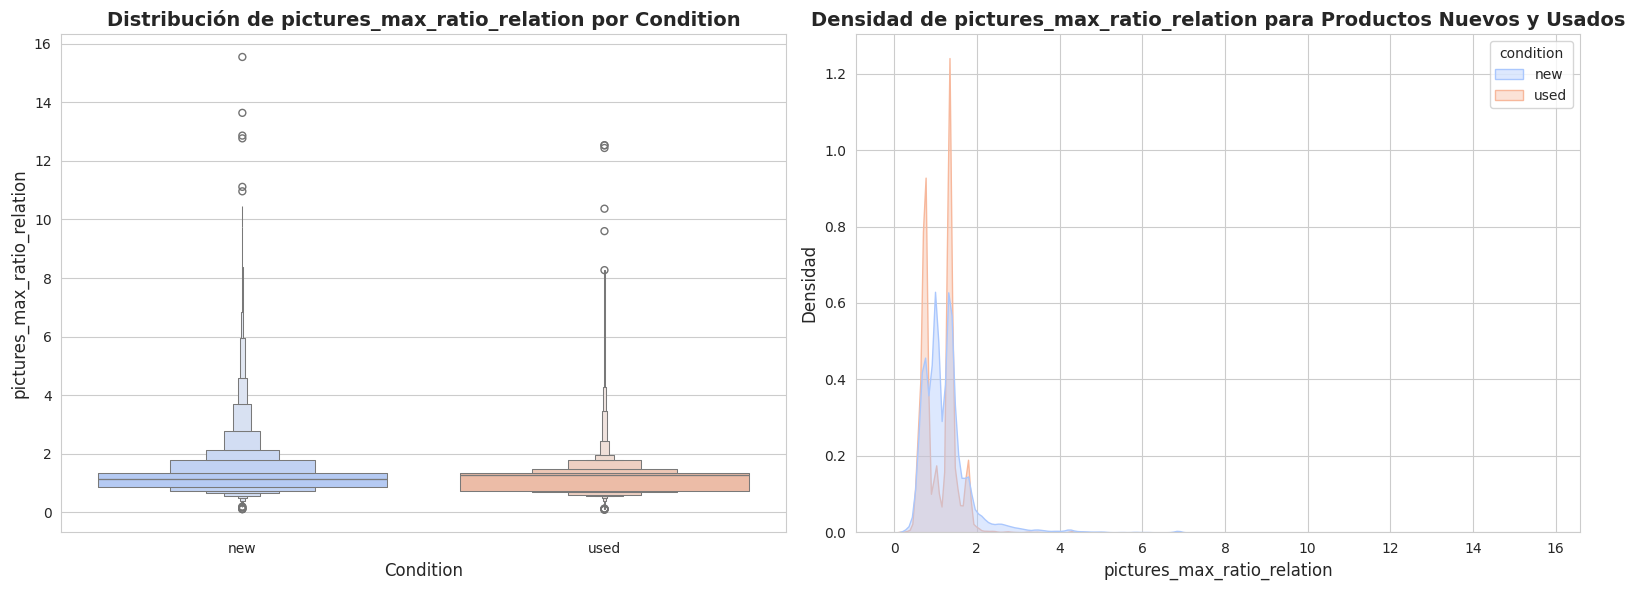

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


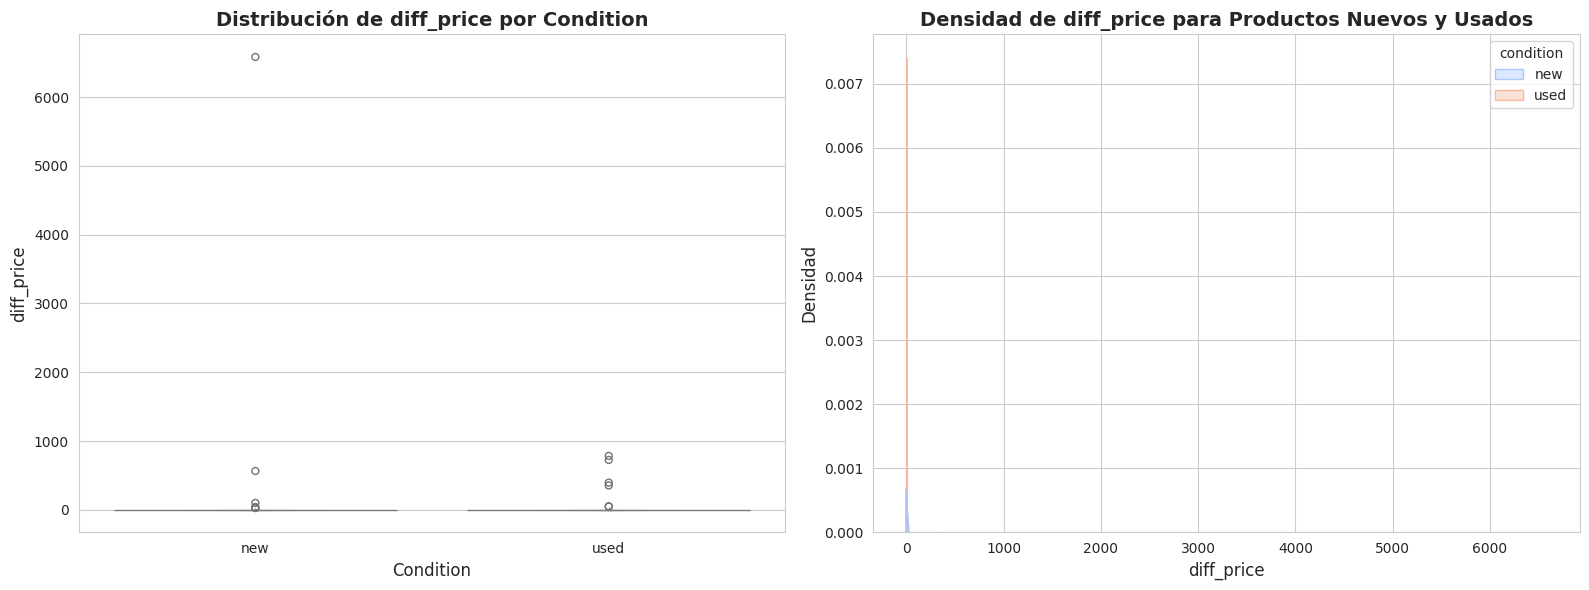

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


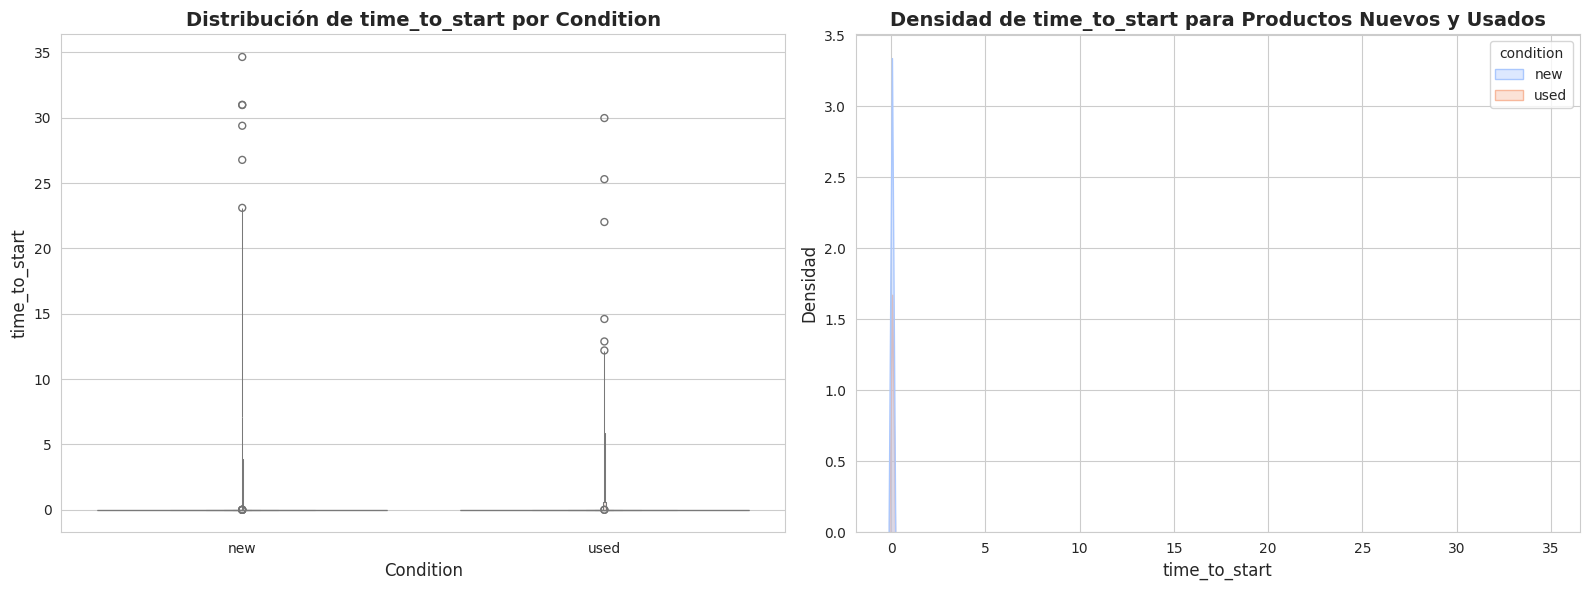

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


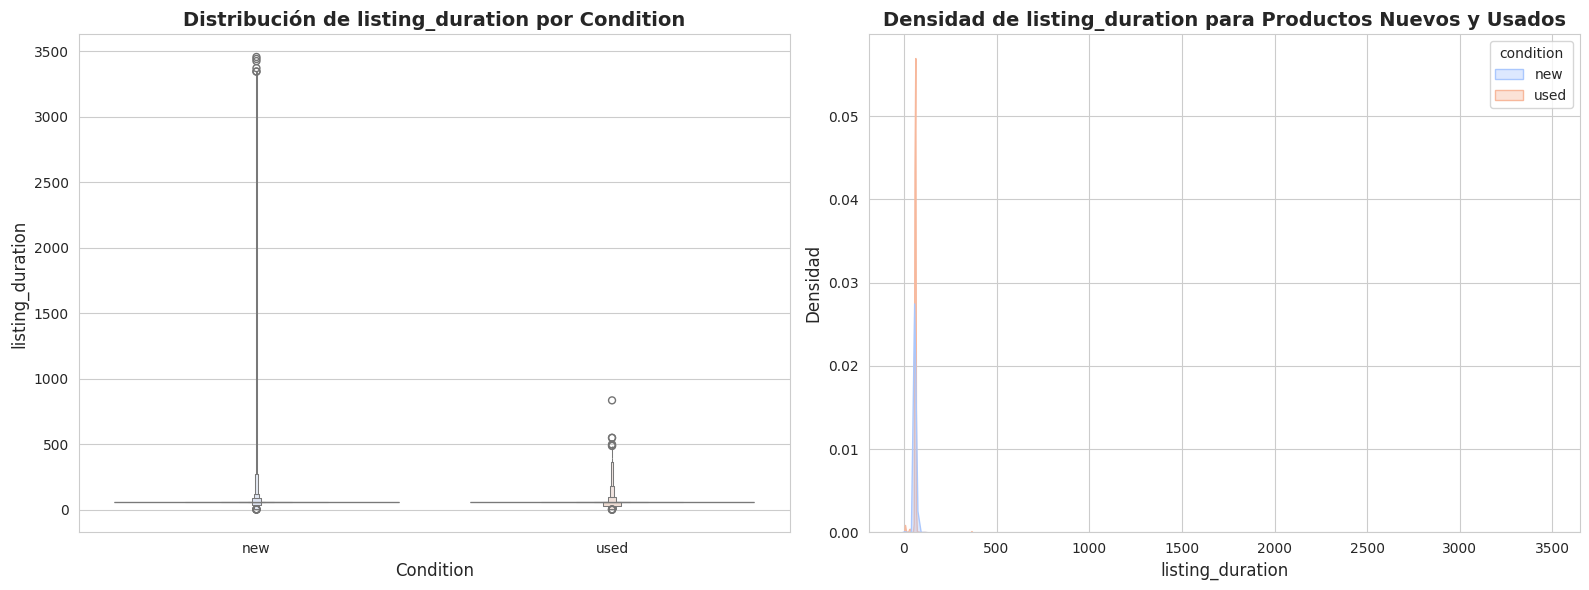

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


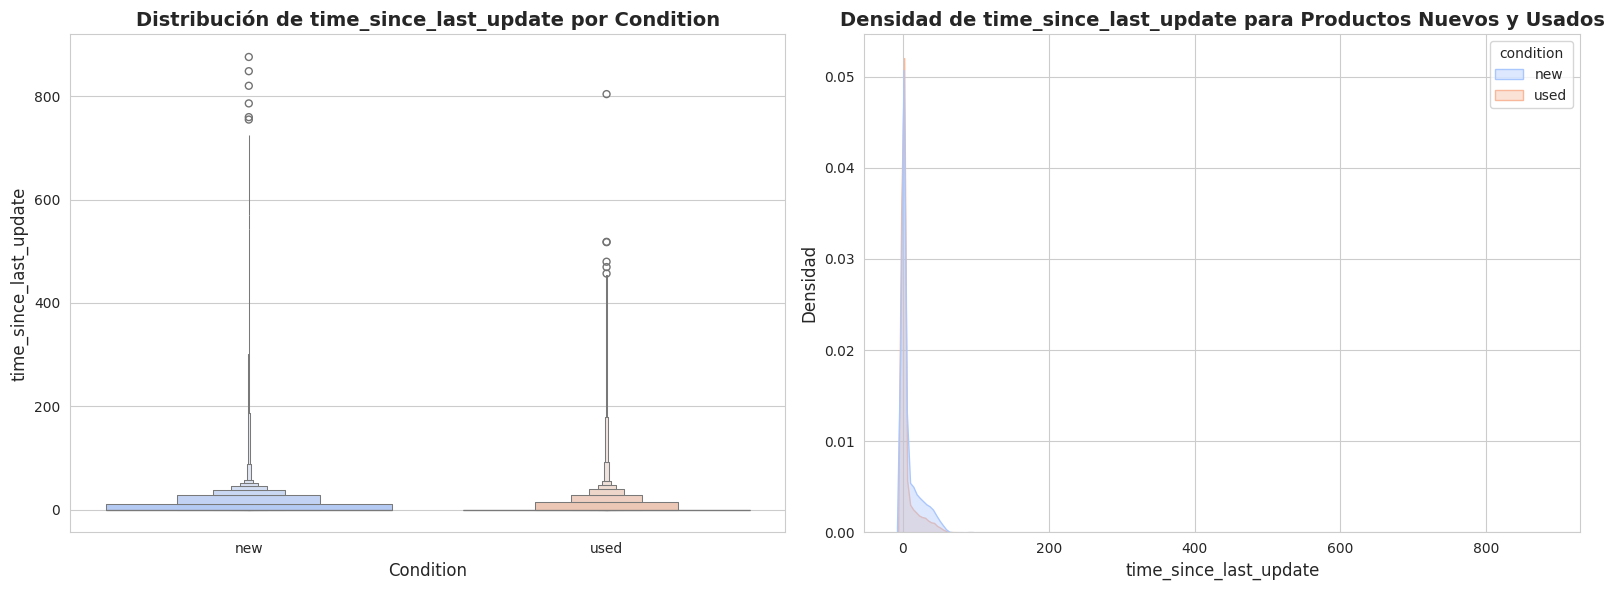

<ipython-input-74-73d81e15fdfa>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])


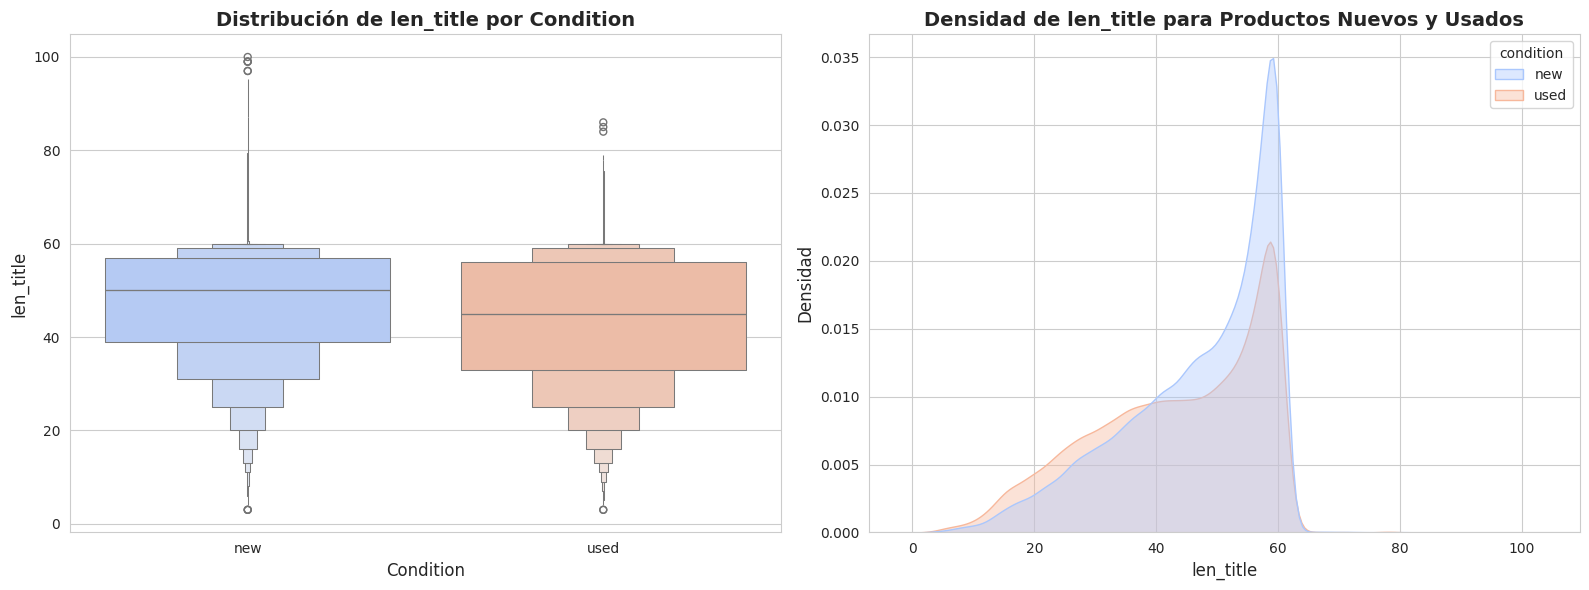

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_vs_condition(df, numeric_col):
    """
    Genera un Boxen Plot y un KDE Plot para analizar la relación entre
    una variable numérica y la condición del producto (nuevo/usado).

    Parámetros:
    - df: DataFrame con la variable numérica y la columna 'condition'.
    - numeric_col: Nombre de la columna numérica a analizar.
    """
    # Verificar que las columnas existen en el DataFrame
    if numeric_col not in df.columns or 'condition' not in df.columns:
        raise ValueError("Las columnas especificadas no existen en el DataFrame.")

    # Filtrar valores nulos
    df_filtered = df[[numeric_col, 'condition']].dropna()

    # Configurar figura
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Boxen Plot: Distribución de la variable numérica por condición
    sns.boxenplot(data=df_filtered, x="condition", y=numeric_col, palette="coolwarm", ax=ax[0])
    ax[0].set_title(f"Distribución de {numeric_col} por Condition", fontsize=14, fontweight="bold")
    ax[0].set_xlabel("Condition")
    ax[0].set_ylabel(numeric_col)

    # KDE Plot: Densidad de la variable numérica por condición
    sns.kdeplot(data=df_filtered, x=numeric_col, hue="condition", fill=True, alpha=0.4, palette="coolwarm", ax=ax[1])
    ax[1].set_title(f"Densidad de {numeric_col} para Productos Nuevos y Usados", fontsize=14, fontweight="bold")
    ax[1].set_xlabel(numeric_col)
    ax[1].set_ylabel("Densidad")

    # Mostrar gráficos
    plt.tight_layout()
    plt.show()

# Generar gráficos para cada variable numérica
for col in type_feature['numeric']:
    plot_numeric_vs_condition(df, col)

**Variables numéricas:**

observamos que algunas variables tienen outliers que no permiten visualizar correctamente el comportamiento respecto a la condición del producto. se tiene que transformar o eliminar los outliers. Estas variables son:

* base_price
* Price
* initial_quantity
* sold_quantity
* available_quantity
* pictures_ratio_relation
* pictures_max_ratio_relation
* diff_price
* time_to_start
* listing_duration
* time_since_last_update

otras variables

* **pictures_width:** observamos que la mayor cantidad de imágenes suelen tener ancho de 375 o 500. la única diferencia es para productos usados que suelen tener mayor cantidad de imágenes de ancho 375 que los productos nuevos

* **pictures_height:** acá vemos que el alto de las imágenes se comporta similar, predominan imágenes de alto 275, 375 y 500, en este caso los productos usados tienen mayor cantidad de imágenes con altura de 375 y 500 que los productos nuevos

* **pictures_max_width:** En el ancho máximo de la imagen si vemos que para productos nuevos suelen ser desde los 400 a los 1050 con una media de 700, para los productos usados si la media es más alta permitiendo imágenes de ancho igual a 900

* **pictures_max_height:** En el alto máximo de la imagen vemos que para productos nuevos suelen ser desde los 375 a los 900 con una media de 600, para los productos usados si la media es más alta permitiendo imágenes de ancho igual a 900, teniendo imágenes con alturas máximas de 1200

* **pictures_area:** si evaluamos el area de las imagenes vemos que los productos usados tienen en su mayoria imagenes con area entre los 170k a 190k pixeles. mientras los productos nuevos suelen tener imágenes con áreas concentradas entre los 120k a 190k pixeles.

* **pictures_max_area:** si evaluamos el area máxima de las imagenes vemos que los productos usados tienen una media de 1M pixeles permitido. los productos nuevos tiene una media de 450k pixeles

* **len_title:** esta variable representa la longitud de los títulos en los productos en donde vemos que no existen diferencias significativas entre productos nuevo/usado

### 5.4 Otros Graficos

In [ ]:
import plotly.graph_objects as go

# Sankey Diagram
categories = list(set(df['categoria_predicha'])) + list(set(df['warranty_class'])) + list(set(df['listing_type_id'])) + list(set(df['condition']))
node_indices = {cat: i for i, cat in enumerate(categories)}

links = []
for col1, col2 in [('categoria_predicha', 'warranty_class'), ('warranty_class', 'listing_type_id'), ('listing_type_id', 'condition')]:
    group = df.groupby([col1, col2]).size().reset_index(name='value')
    for _, row in group.iterrows():
        links.append({'source': node_indices[row[col1]], 'target': node_indices[row[col2]], 'value': row['value']})


# Definir colores más atractivos
node_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"
] * (len(categories) // 10 + 1)  # Repetimos la paleta si hay más categorías

link_colors = ["rgba(31, 119, 180, 0.4)", "rgba(255, 127, 14, 0.4)", "rgba(44, 160, 44, 0.4)",
               "rgba(214, 39, 40, 0.4)", "rgba(148, 103, 189, 0.4)"] * (len(links) // 5 + 1)

fig_sankey = go.Figure(go.Sankey(
    node=dict(
        label=categories,
        color=node_colors[:len(categories)],  # Ajustar al número de categorías
    ),
    link=dict(
        source=[l['source'] for l in links],
        target=[l['target'] for l in links],
        value=[l['value'] for l in links],
        color=link_colors[:len(links)],  # Ajustar al número de enlaces
    )
))

fig_sankey.update_layout(
    title_text="Flujo de Productos en MercadoLibre",
    font_size=12,
    plot_bgcolor="white"
)

fig_sankey.show()

Se puede observar que los productos con garantía por defectos y garantía basada en reputación tienen una mayor tendencia a finalizar en la categoría de productos nuevos, mientras que aquellos sin garantía están más asociados con productos usados. Esto sugiere que los vendedores de artículos nuevos buscan ofrecer mayor seguridad a los compradores, mientras que en el mercado de productos usados, la ausencia de garantía es una característica común.

En cuanto a los planes de publicación, los listados de nivel superior como 'gold' y 'gold_pro' concentran una mayor proporción de productos nuevos, lo que indica que los vendedores de estos artículos están dispuestos a pagar por mayor visibilidad. Por otro lado, los productos con planes de publicación gratuitos o de menor costo, como 'free' y 'silver', muestran una mayor presencia de artículos usados, lo que sugiere que los vendedores de articulos usados buscan minimizar su costo de venta. A nivel de categorías, productos de electrónica, celulares y electrodomésticos parecen estar más alineados con publicaciones pagas y productos nuevos, mientras que categorías como libros o accesorios para vehículos muestran una mayor mezcla entre productos nuevos y usados, dependiendo del tipo de garantía y visibilidad elegida.

Top 15 variables correlacionadas con 'conditio':
initial_quantity: -0.5335 (|0.5335|)
available_quantity: -0.5269 (|0.5269|)
listing_type_id_free: 0.4846 (|0.4846|)
sold_quantity: -0.3237 (|0.3237|)
pictures_max_height: 0.2880 (|0.2880|)
pictures_max_area: 0.2800 (|0.2800|)
pictures_max_width: 0.2163 (|0.2163|)
base_price: -0.2023 (|0.2023|)
price: -0.2023 (|0.2023|)
warranty_class_garantia media: -0.1945 (|0.1945|)
automatic_relist: -0.1862 (|0.1862|)
listing_type_id_silver: -0.1683 (|0.1683|)
pictures_height: 0.1675 (|0.1675|)
title_class_usado: 0.1582 (|0.1582|)
listing_type_id_gold_special: -0.1562 (|0.1562|)


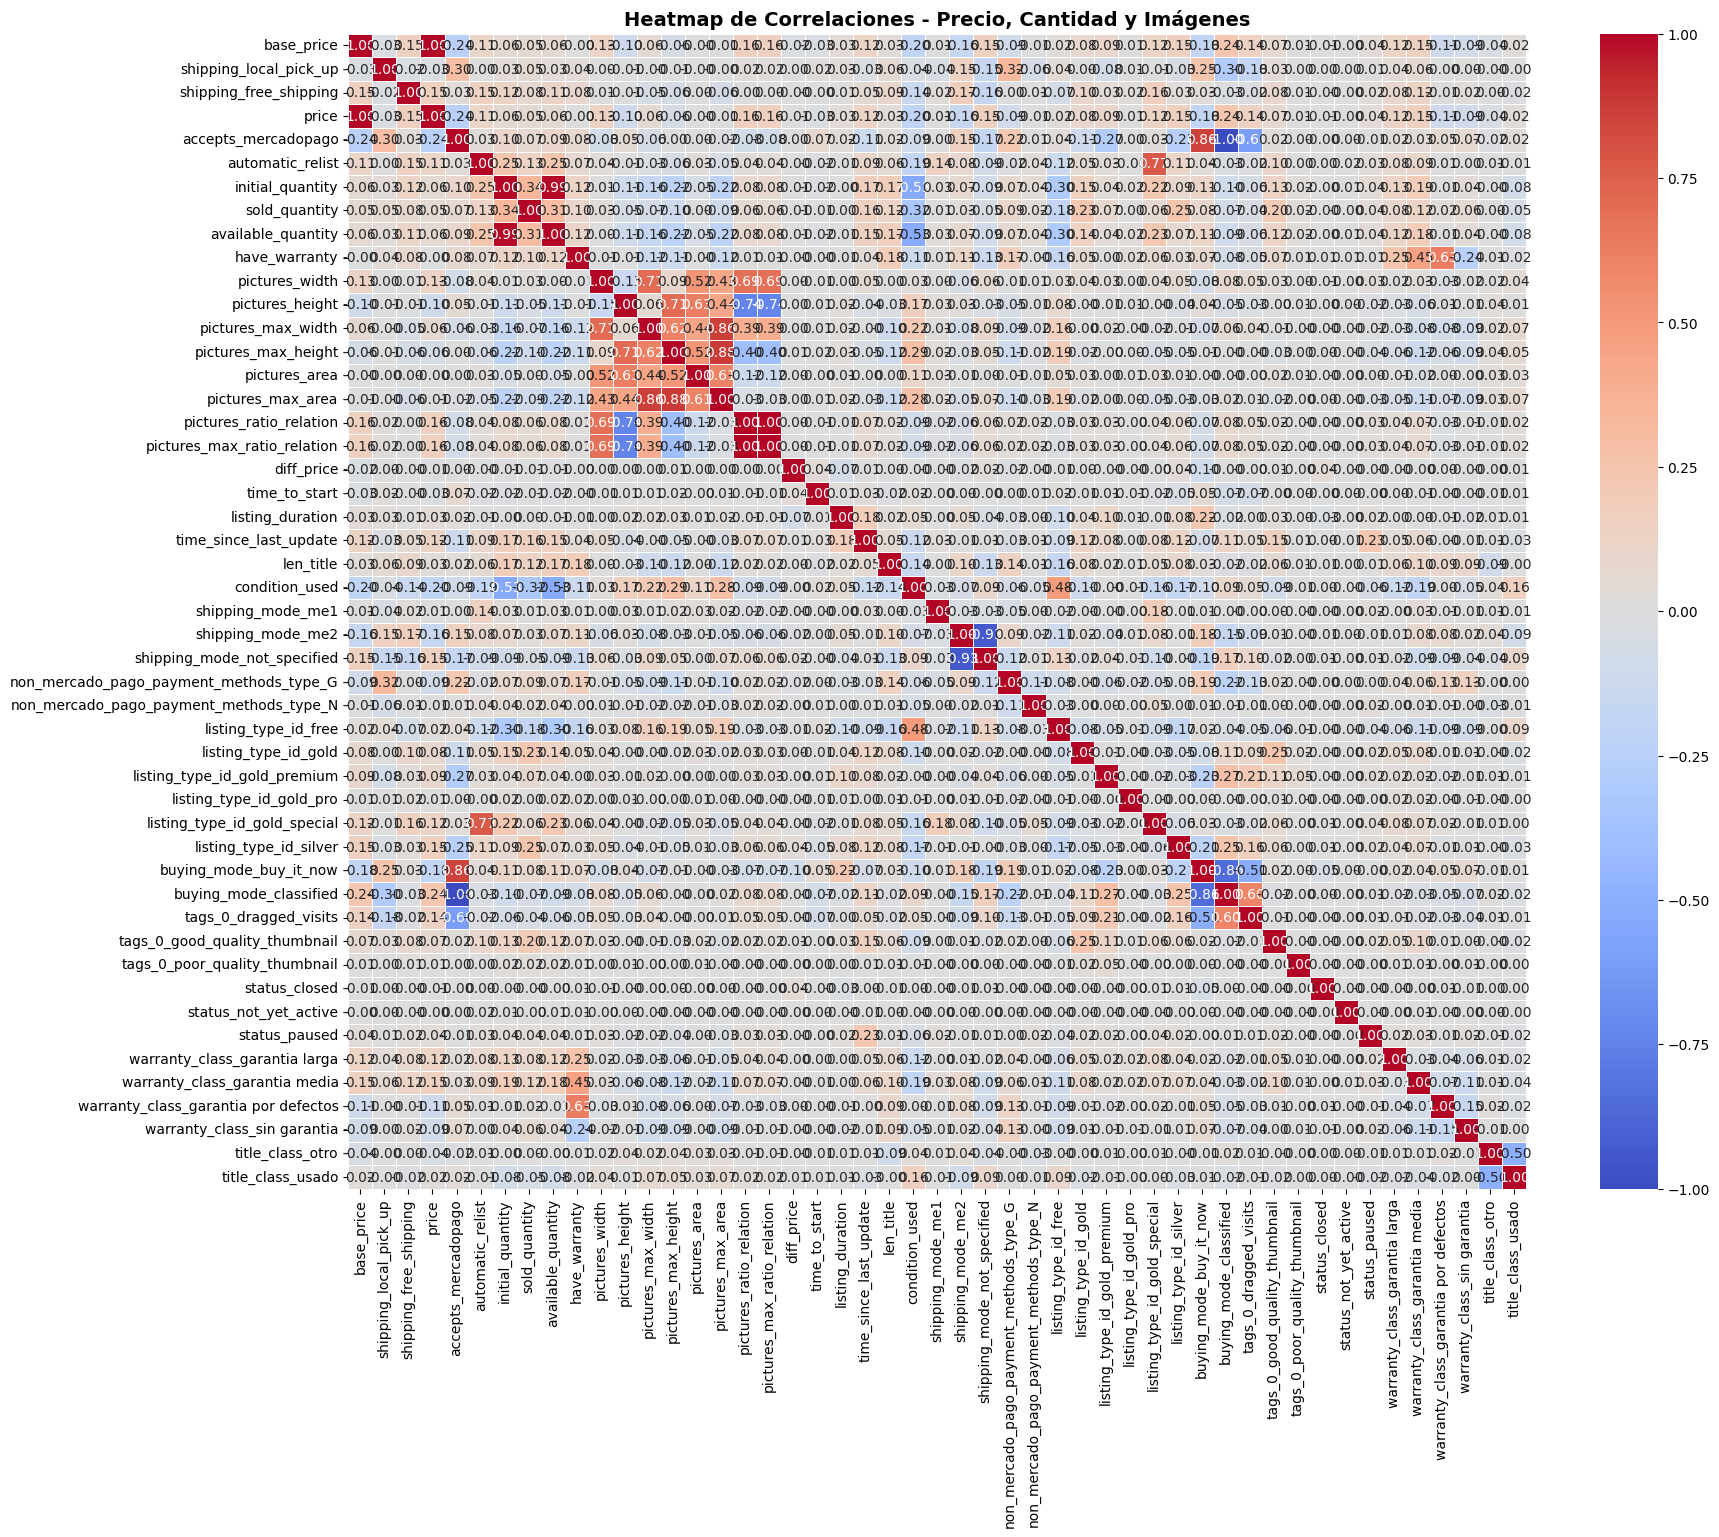

In [ ]:
def get_top_correlated_vars(df, col_name, method='pearson', top_n=6):
    """
    Obtiene las variables más correlacionadas con cualquier variable que contenga `col_name`.

    Parámetros:
    - df: DataFrame con los datos.
    - col_name: Parte del nombre de la variable a buscar (ej. 'warranty_').
    - method: Método de correlación ('pearson', 'spearman', 'kendall').
    - top_n: Número de variables a retornar (las más correlacionadas positiva y negativamente).

    Retorna:
    - Lista con las `top_n` variables más correlacionadas.
    """
    # Convertir variables categóricas en numéricas con One-Hot Encoding
    df_encoded = pd.get_dummies(df, drop_first=True)

    # Calcular matriz de correlación
    corr_matrix = df_encoded.corr(method=method)

    # Filtrar solo las variables que contienen col_name
    target_corr = corr_matrix.filter(like=col_name, axis=0).dropna()

    if target_corr.empty:
        print(f"No se encontraron variables que contengan '{col_name}' en la matriz de correlación.")
        return []

    # Promedio de correlación con todas las variables que coincidan con col_name
    mean_corr = target_corr.mean()

    # Eliminar las variables que contienen col_name para evitar autoselección
    mean_corr_filtered = mean_corr[~mean_corr.index.str.contains(col_name)]

    # Seleccionar las top_n variables más correlacionadas (positiva y negativa)
    sorted_corr = mean_corr_filtered.abs().sort_values(ascending=False)
    top_vars = sorted_corr.head(top_n).index.tolist()

    # Imprimir los valores de correlación reales junto con los absolutos
    print(f"Top {top_n} variables correlacionadas con '{col_name}':")
    for var in top_vars:
        print(f"{var}: {mean_corr_filtered[var]:.4f} (|{sorted_corr[var]:.4f}|)")

    # Crear heatmap
    plt.figure(figsize=(19,15))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

    # Personalizar gráfico
    plt.title("Heatmap de Correlaciones - Precio, Cantidad y Imágenes", fontsize=14, fontweight='bold')
    plt.show()

    return top_vars

top_vars_condition = get_top_correlated_vars(
    df.drop(columns=['title_clean',  'categoria_predicha', 'seller_address_city.name', 'seller_address_state.name',
                                             'non_mercado_pago_payment_methods_description']),
    'conditio',
    method='spearman',
    top_n=15)


* **initial_quantity** [-0.5335]: Los productos usados tienden a listarse en menores cantidades, usualmente si es usado venden solo 1 unidad en comparación con productos nuevos

* **available_quantity** [-0.5269]: La disponibilidad de productos usados es generalmente más baja, usualmente 1 unidad. Lo que indica una menor oferta en comparación con productos nuevos

* **listing_type_id_free** [0.4846]: Los productos usados se asocian más frecuentemente con publicaciones gratuitas, lo que sugiere que los vendedores invierten menos en promoción

* **sold_quantity** [-0.3237]: Los productos usados tienen menores volúmenes de venta, relacionado a que suelen vender una o pocas unidades de los productos usados

* **pictures_max_height** [0.2880]: Las publicaciones de productos usados suelen tener imágenes más altas

* **pictures_max_area** [0.2800]: Los productos usados tienden a incluir imágenes con mayor área, posiblemente ya que muchas imagenes son tomadas con telefonos en algunos casos.  

* **pictures_max_width** [0.2163]: La anchura de las imágenes en productos usados es mayor

* **base_price** [-0.2023]: Los productos usados tienen precios base más bajos en comparación con otros productos, reflejando su menor valor por su uso

* **price** [-0.2023]: El precio final de los productos usados también es menor

* **warranty_class_garantia media** [-0.1945]: Los productos usados cuentan con menos garantía, en la mayoria de los casos sin garantia

* **automatic_relist** [-0.1862]: La opción de republicación automática es menos común en productos usados, posiblemente debido a su menor rotación o que solo es 1 producto

* **listing_type_id_silver** [-0.1683]: Los productos usados tienen menos presencia en planes de publicación pagos tipo 'silver', lo que sugiere una menor inversión en visibilidad.  

* **pictures_height** [0.1675]: Los productos usados suelen presentar imágenes más altas

* **title_class_usado** [0.1582]: Los títulos de los productos usados tienen características distintas, diferenciándolos claramente de los productos nuevos.  

* **listing_type_id_gold_special** [-0.1562]: Los productos usados utilizan menos planes de promoción premium como 'gold special'


# 6 - Pre procesamiento:



### 6.1 Imputar datos faltantes

In [ ]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

def impute_missing_values(df, categorical_strategy='mode', numerical_strategy='median', use_knn=False, n_neighbors=5):
    """
    Imputa valores faltantes en un DataFrame de acuerdo con el tipo de variable.

    Parámetros:
    - df: DataFrame con los datos.
    - categorical_strategy: Estrategia para imputar variables categóricas ('mode' por defecto).
    - numerical_strategy: Estrategia para imputar variables numéricas ('median', 'mean').
    - use_knn: Si True, usa KNN Imputer en lugar de los métodos básicos.
    - n_neighbors: Número de vecinos a usar en KNN.

    Retorna:
    - DataFrame con los valores imputados.
    """
    df_imputed = df.copy()

    # Identificar columnas categóricas y numéricas
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    # Imputación para variables categóricas
    for col in categorical_cols:
        if df_imputed[col].isnull().sum() > 0:
            if categorical_strategy == 'mode':
                mode_value = df_imputed[col].mode()[0]  # Valor más frecuente
                df_imputed[col].fillna(mode_value, inplace=True)

    # Imputación para variables numéricas
    if use_knn:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])
    else:
        for col in numerical_cols:
            if df_imputed[col].isnull().sum() > 0:
                if numerical_strategy == 'median':
                    df_imputed[col].fillna(df_imputed[col].median(), inplace=True)
                elif numerical_strategy == 'mean':
                    df_imputed[col].fillna(df_imputed[col].mean(), inplace=True)

    return df_imputed

df_imputed = impute_missing_values(df, categorical_strategy='mode', numerical_strategy='median')
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   seller_address_state.name                     90000 non-null  object 
 1   seller_address_city.name                      90000 non-null  object 
 2   condition                                     90000 non-null  object 
 3   base_price                                    90000 non-null  float64
 4   shipping_local_pick_up                        90000 non-null  bool   
 5   shipping_free_shipping                        90000 non-null  bool   
 6   shipping_mode                                 90000 non-null  object 
 7   non_mercado_pago_payment_methods_description  90000 non-null  object 
 8   non_mercado_pago_payment_methods_type         90000 non-null  object 
 9   listing_type_id                               90000 non-null 

### 6.2 Distribución de los datos


📌 Analizando: base_price
Resultados de Transformaciones:
               Normality_p  Skewness
Original      0.000000e+00  1.823207
Log           0.000000e+00 -0.079096
Sqrt          0.000000e+00  0.973294
Box-Cox       0.000000e+00 -0.005246
Yeo-Johnson  2.485713e-223 -0.005246
🏆 Mejor transformación aplicada: Box-Cox


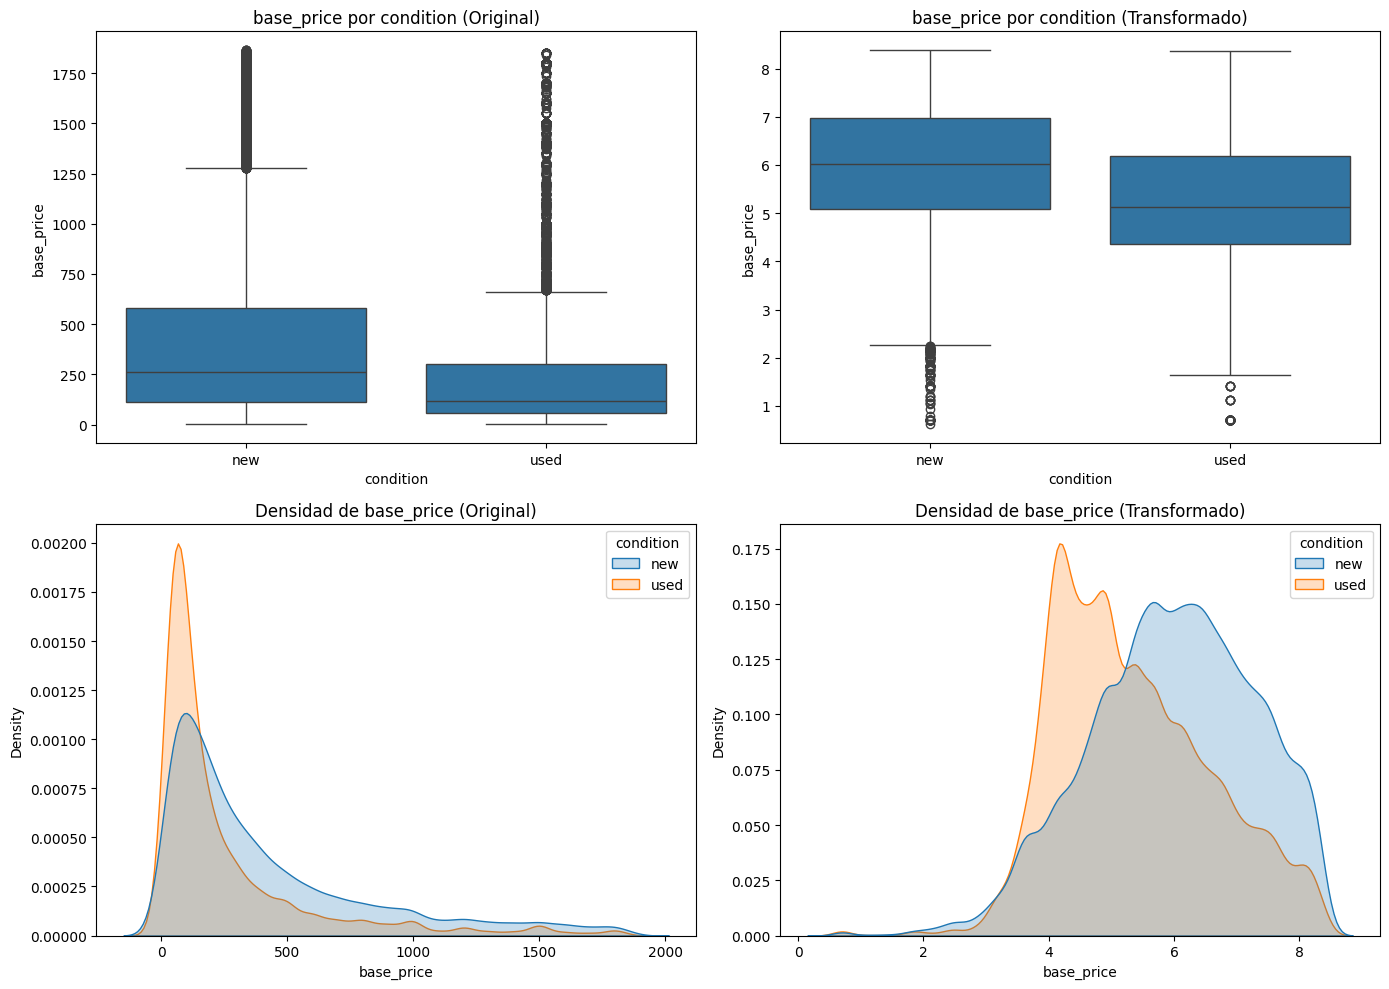


📌 Analizando: price
Resultados de Transformaciones:
               Normality_p  Skewness
Original      0.000000e+00  1.367222
Log           0.000000e+00 -0.232120
Sqrt          0.000000e+00  0.684177
Box-Cox       0.000000e+00 -0.019007
Yeo-Johnson  2.263269e-241 -0.019007
🏆 Mejor transformación aplicada: Box-Cox


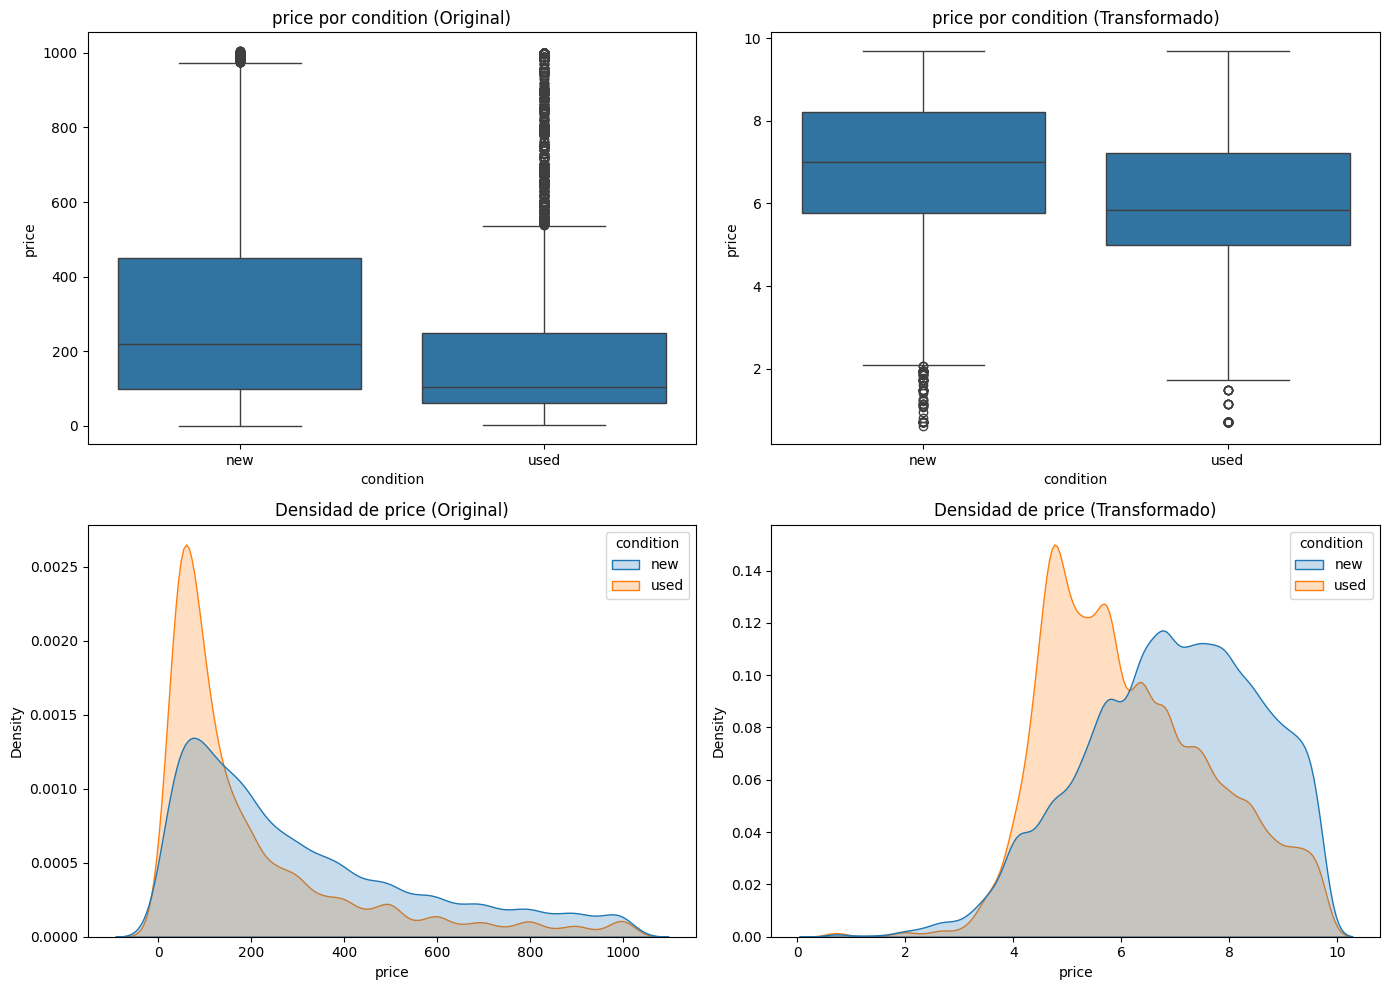


📌 Analizando: initial_quantity
Resultados de Transformaciones:
             Normality_p  Skewness
Original             0.0  3.216551
Log                  0.0  1.965550
Sqrt                 0.0  2.534871
Box-Cox              0.0  1.065654
Yeo-Johnson          0.0  1.065654
🏆 Mejor transformación aplicada: Yeo-Johnson


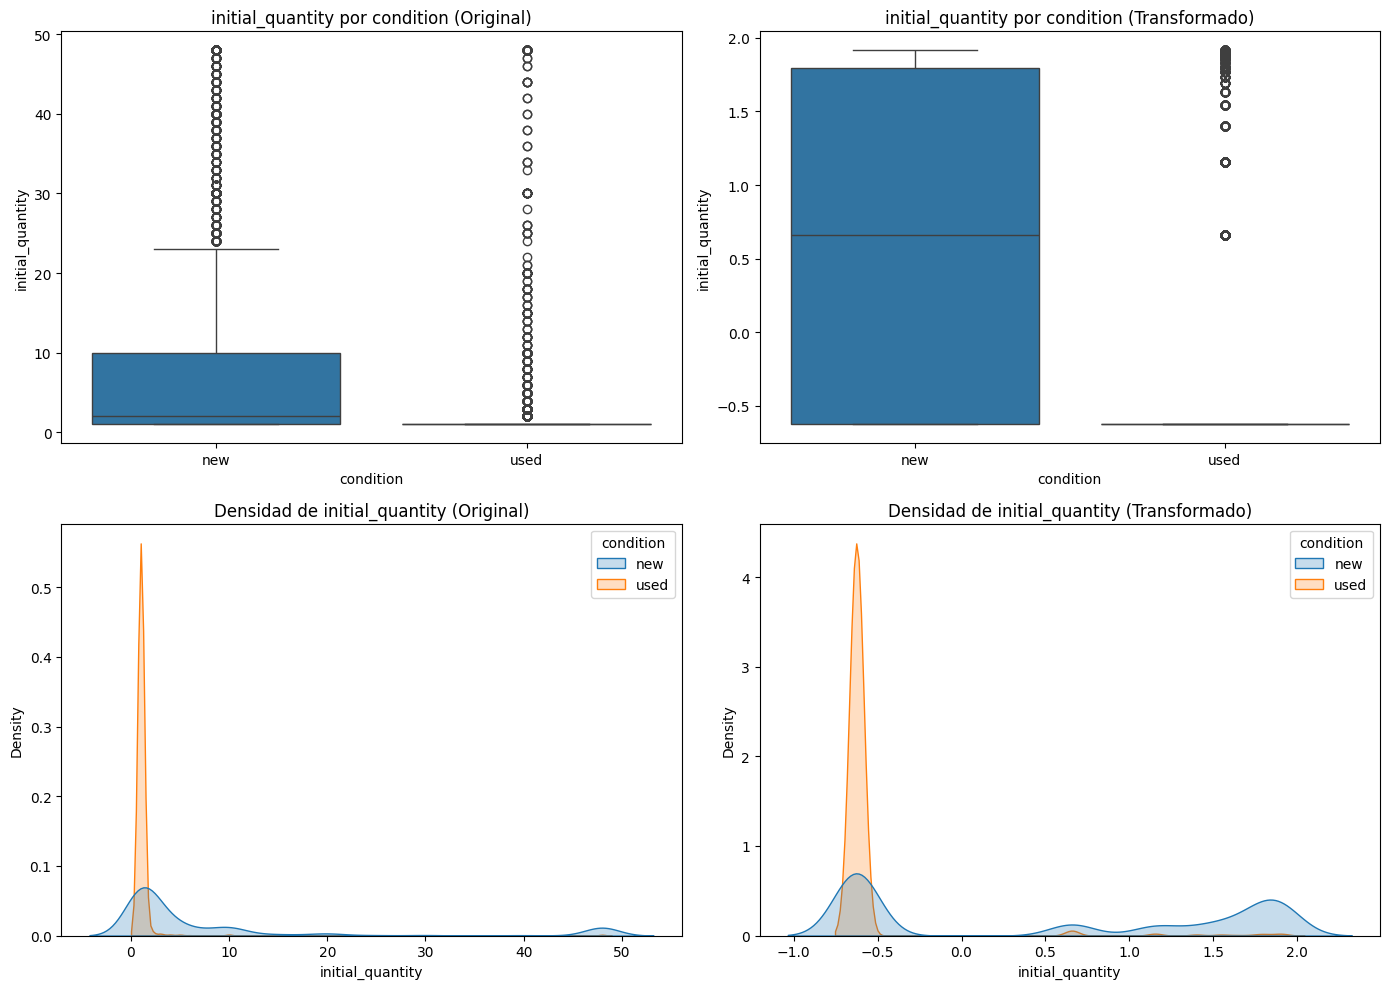


📌 Analizando: sold_quantity
Resultados de Transformaciones:
             Normality_p  Skewness
Original             0.0  2.842589
Log                  0.0  2.330927
Sqrt                 0.0  2.226367
Yeo-Johnson          0.0  1.774151
🏆 Mejor transformación aplicada: Yeo-Johnson


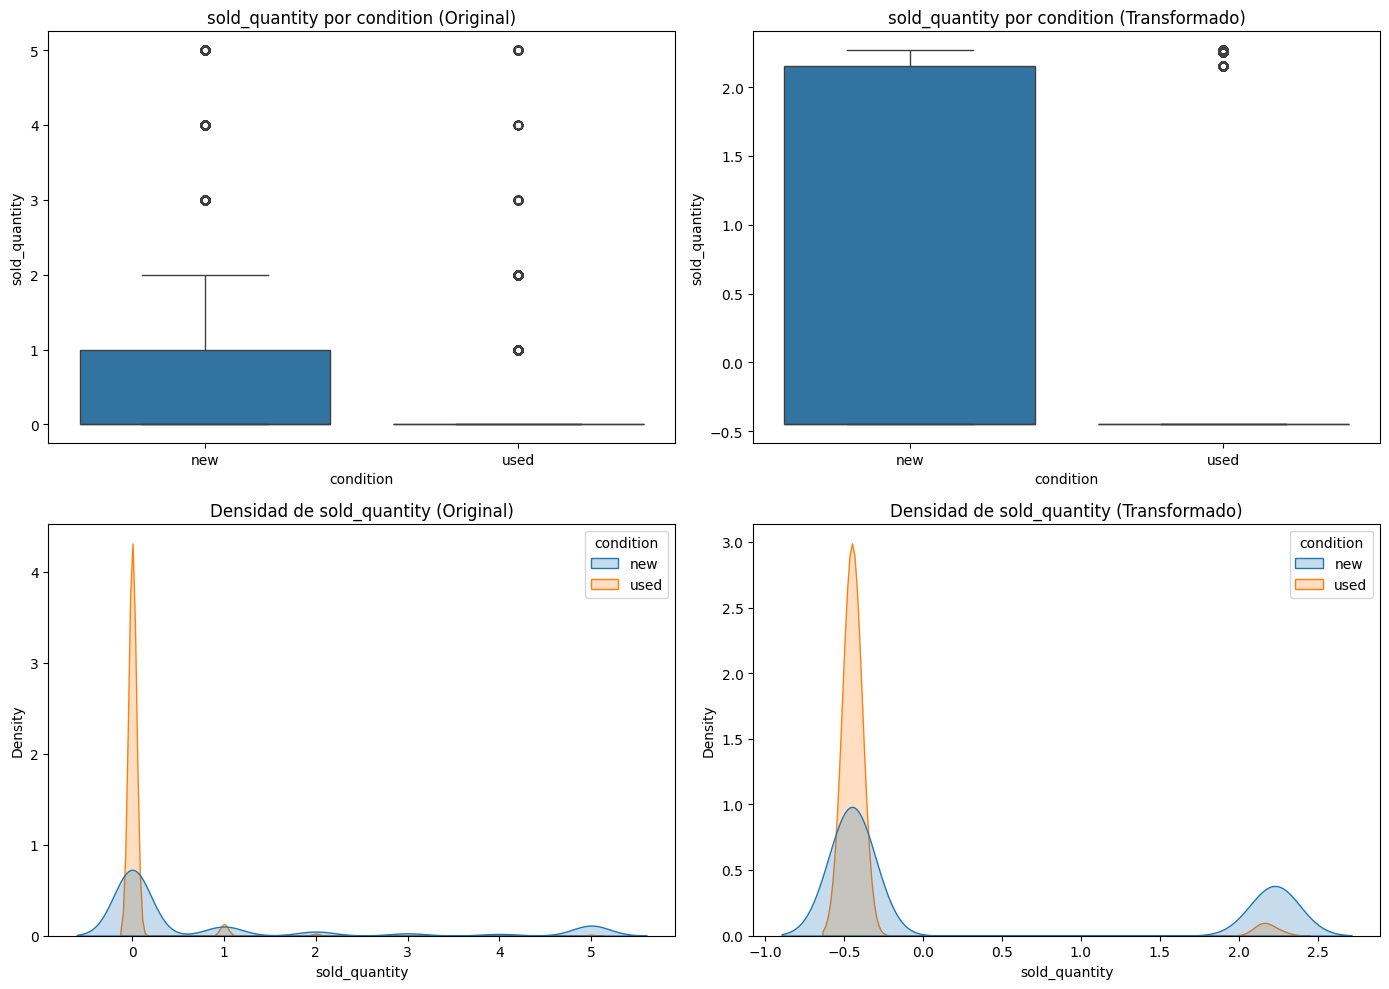


📌 Analizando: available_quantity


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning:


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning:




Resultados de Transformaciones:
             Normality_p  Skewness
Original             0.0  3.045418
Log                  0.0  2.849288
Sqrt                 0.0  2.889391
Box-Cox              0.0  2.490221
Yeo-Johnson          0.0  2.490221
🏆 Mejor transformación aplicada: Yeo-Johnson


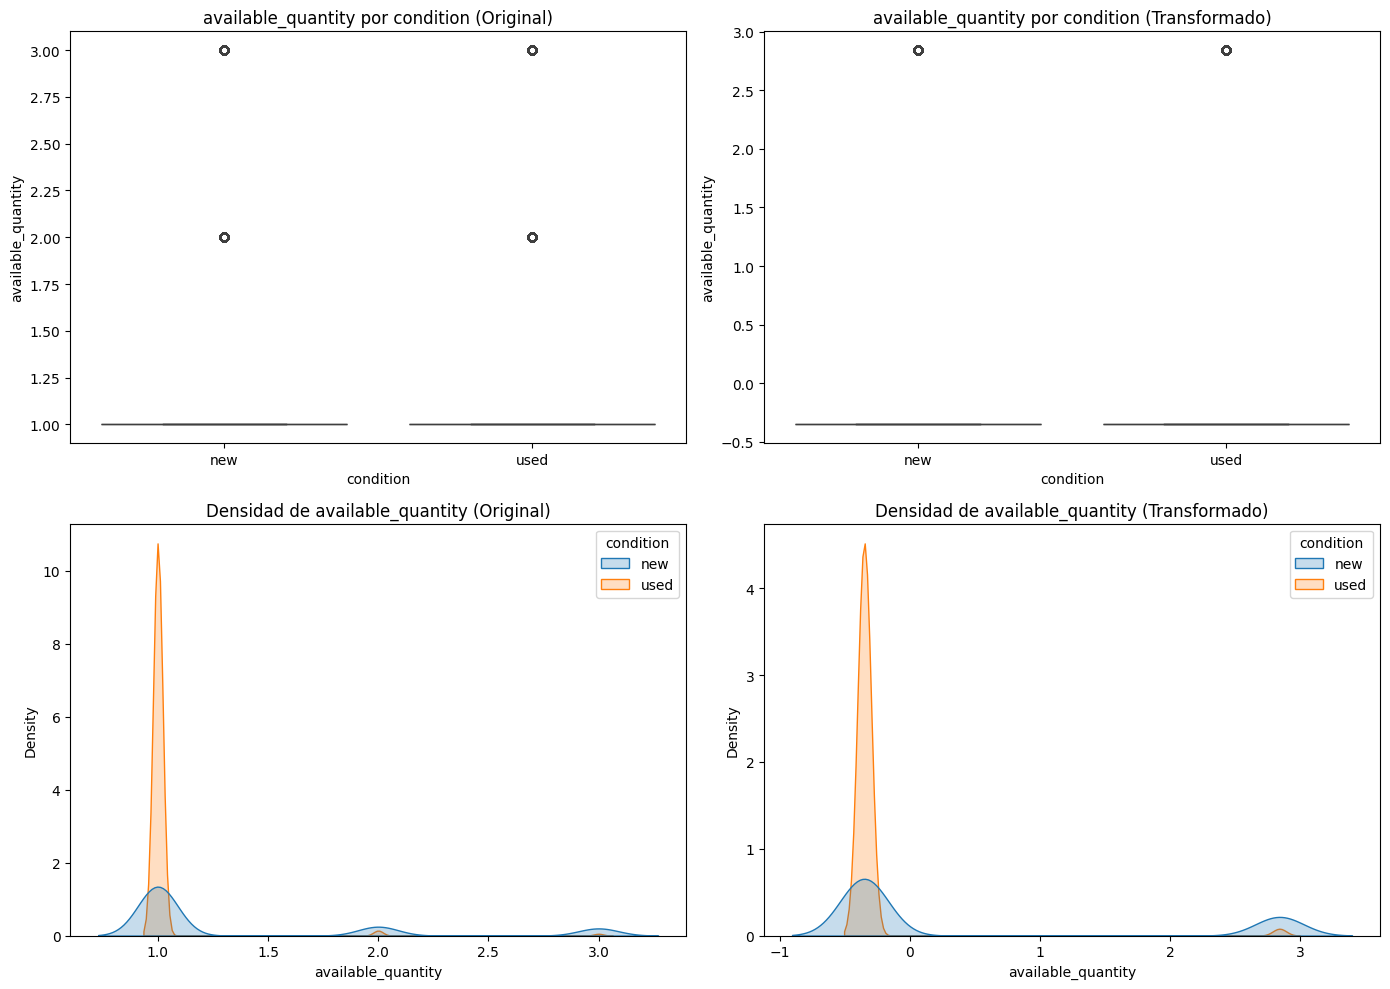


📌 Analizando: pictures_ratio_relation
Resultados de Transformaciones:
             Normality_p  Skewness
Original             0.0  0.344137
Log                  0.0  0.070346
Sqrt                 0.0  0.073291
Box-Cox              0.0  0.013335
Yeo-Johnson          0.0  0.013335
🏆 Mejor transformación aplicada: Yeo-Johnson


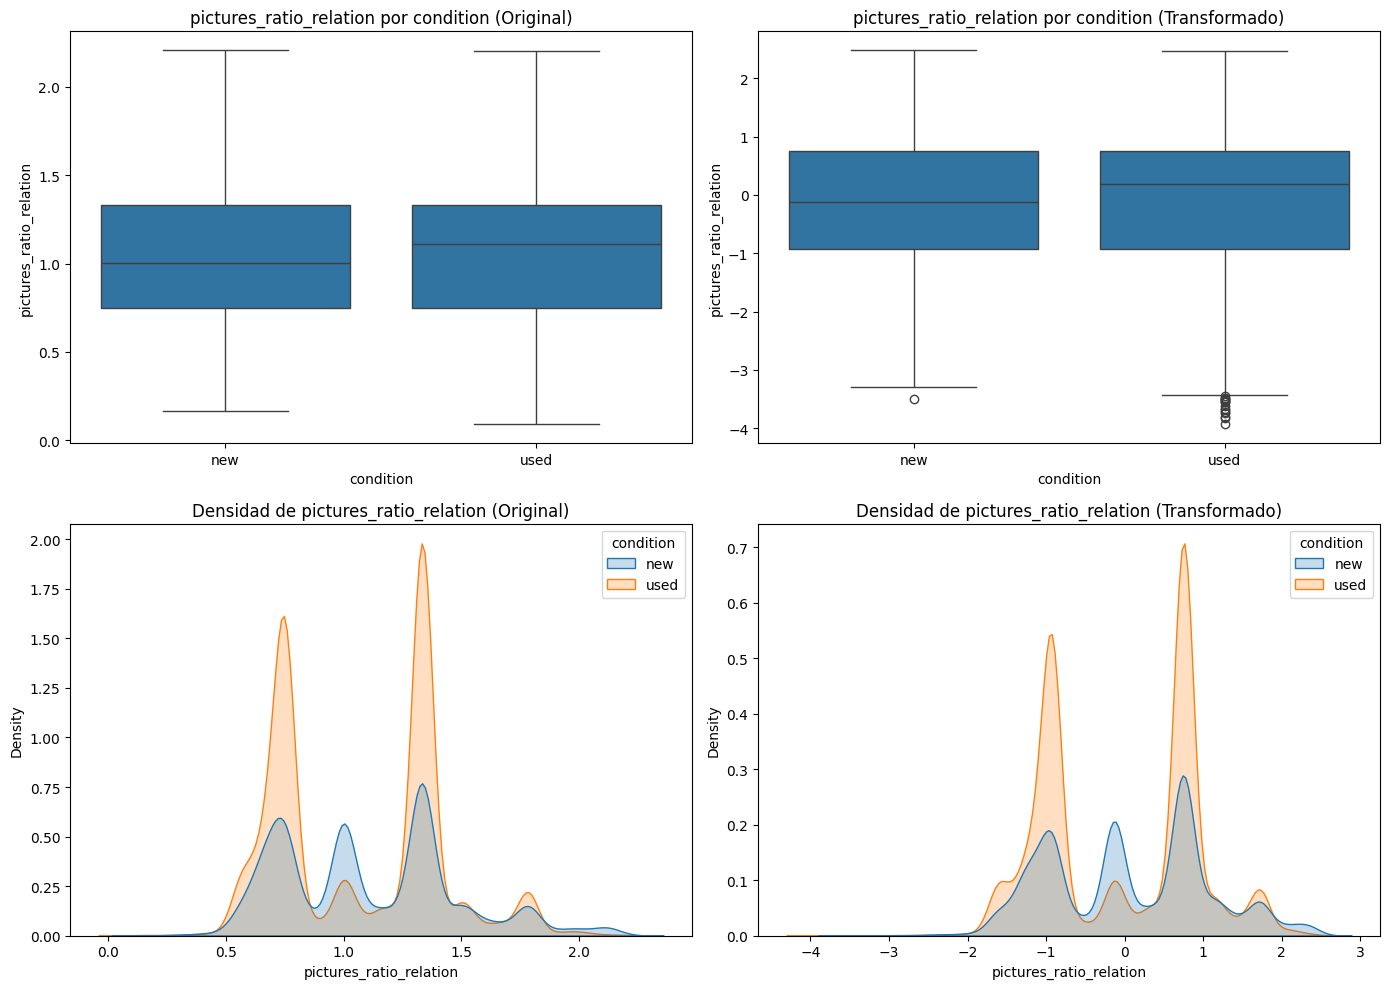


📌 Analizando: pictures_max_ratio_relation
Resultados de Transformaciones:
             Normality_p  Skewness
Original             0.0  0.341001
Log                  0.0  0.068210
Sqrt                 0.0  0.071149
Box-Cox              0.0  0.012972
Yeo-Johnson          0.0  0.012972
🏆 Mejor transformación aplicada: Box-Cox


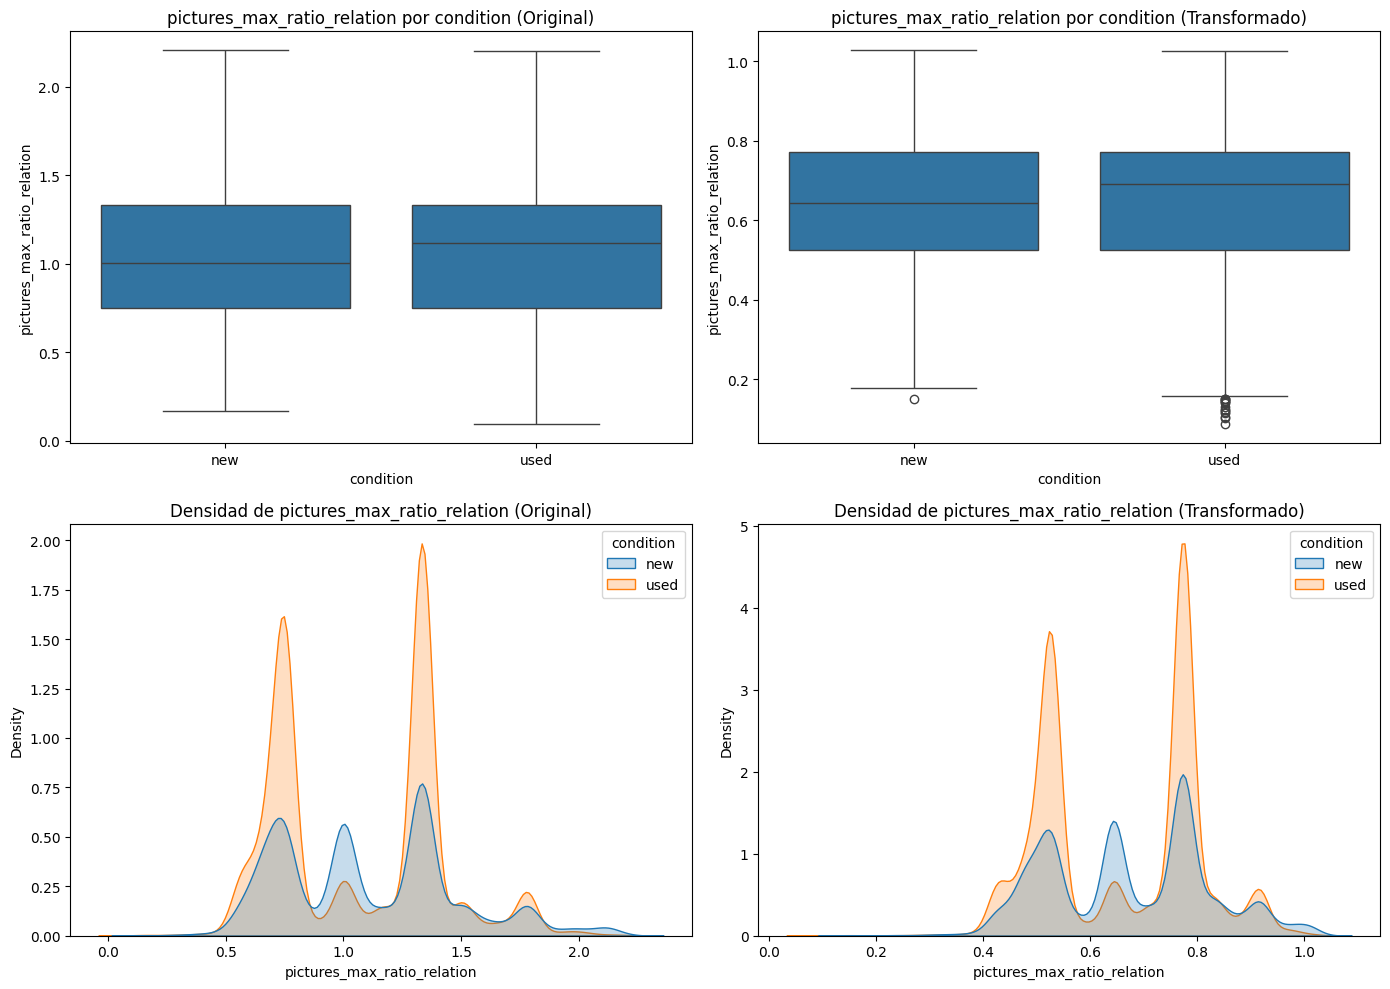

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize

def detect_outliers(df, column, method, threshold):
    """
    Detecta outliers según el método especificado.
    """
    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    elif method == 'winsor':
        df_clean = df.copy()
        df_clean[column] = winsorize(df[column], limits=(0, 1 - threshold))
    else:
        raise ValueError("Método de detección de outliers no válido")

    return df_clean

def evaluate_transformations(df, column):
    """
    Prueba varias transformaciones y selecciona la mejor según skewness.
    """
    transformations = {
        'Original': df[column],
        'Log': np.log1p(df[column]),
        'Sqrt': np.sqrt(df[column]),
        'Box-Cox': stats.boxcox(df[column] + 1)[0] if (df[column] > 0).all() and len(df[column].unique()) > 1 else None,
        'Yeo-Johnson': PowerTransformer(method='yeo-johnson').fit_transform(df[[column]]).flatten()
    }

    results = {}
    for key, transformed_data in transformations.items():
        if transformed_data is None:
            continue

        normality_test_p = stats.shapiro(transformed_data)[1] if len(transformed_data) < 5000 else stats.kstest(transformed_data, 'norm')[1]
        skewness = stats.skew(transformed_data)
        results[key] = {'Normality_p': normality_test_p, 'Skewness': skewness}

    results_df = pd.DataFrame(results).T
    best_transformation = results_df['Skewness'].abs().idxmin()

    print("Resultados de Transformaciones:")
    print(results_df)

    df_transformed = df.copy()
    df_transformed[column] = transformations[best_transformation]

    return df_transformed, best_transformation

def plot_distributions(df_original, df_transformed, column, condition_col='condition'):
    """
    Grafica boxplots y distribuciones de densidad antes y después de la transformación.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    sns.boxplot(data=df_original, x=condition_col, y=column, ax=axes[0, 0])
    axes[0, 0].set_title(f'{column} por {condition_col} (Original)')

    sns.boxplot(data=df_transformed, x=condition_col, y=column, ax=axes[0, 1])
    axes[0, 1].set_title(f'{column} por {condition_col} (Transformado)')

    sns.kdeplot(data=df_original, x=column, hue=condition_col, fill=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'Densidad de {column} (Original)')

    sns.kdeplot(data=df_transformed, x=column, hue=condition_col, fill=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'Densidad de {column} (Transformado)')

    plt.tight_layout()
    plt.show()

def process_numerical_variable(df, column, method, threshold):
    """
    Pipeline completo para procesar variables numéricas.
    """
    print(f"\n📌 Analizando: {column}")

    df_clean = detect_outliers(df, column, method, threshold)
    df_transformed, best_transformation = evaluate_transformations(df_clean, column)
    print(f"🏆 Mejor transformación aplicada: {best_transformation}")

    plot_distributions(df_clean, df_transformed, column)

    return df_transformed

outlier_methods = {
    "base_price": ('iqr', 1.5),
    "price": ('iqr', 1.5),
    "initial_quantity": ('winsor', 0.95),
    "sold_quantity": ('winsor', 0.95),
    "available_quantity": ('iqr', 1.5),
    "pictures_ratio_relation": ('iqr', 1.5),
    "pictures_max_ratio_relation": ('iqr', 1.5),

}

df_transformed = df_imputed.copy()
for col, (method, threshold) in outlier_methods.items():
    df_transformed = process_numerical_variable(df_transformed, col, method, threshold)

Top 10 variables correlacionadas con 'conditio':
initial_quantity: -0.3735 (|0.3735|)
available_quantity: -0.3600 (|0.3600|)
sold_quantity: -0.3145 (|0.3145|)
base_price: -0.2725 (|0.2725|)
price: -0.2725 (|0.2725|)
pictures_ratio_relation: -0.0329 (|0.0329|)
pictures_max_ratio_relation: -0.0323 (|0.0323|)


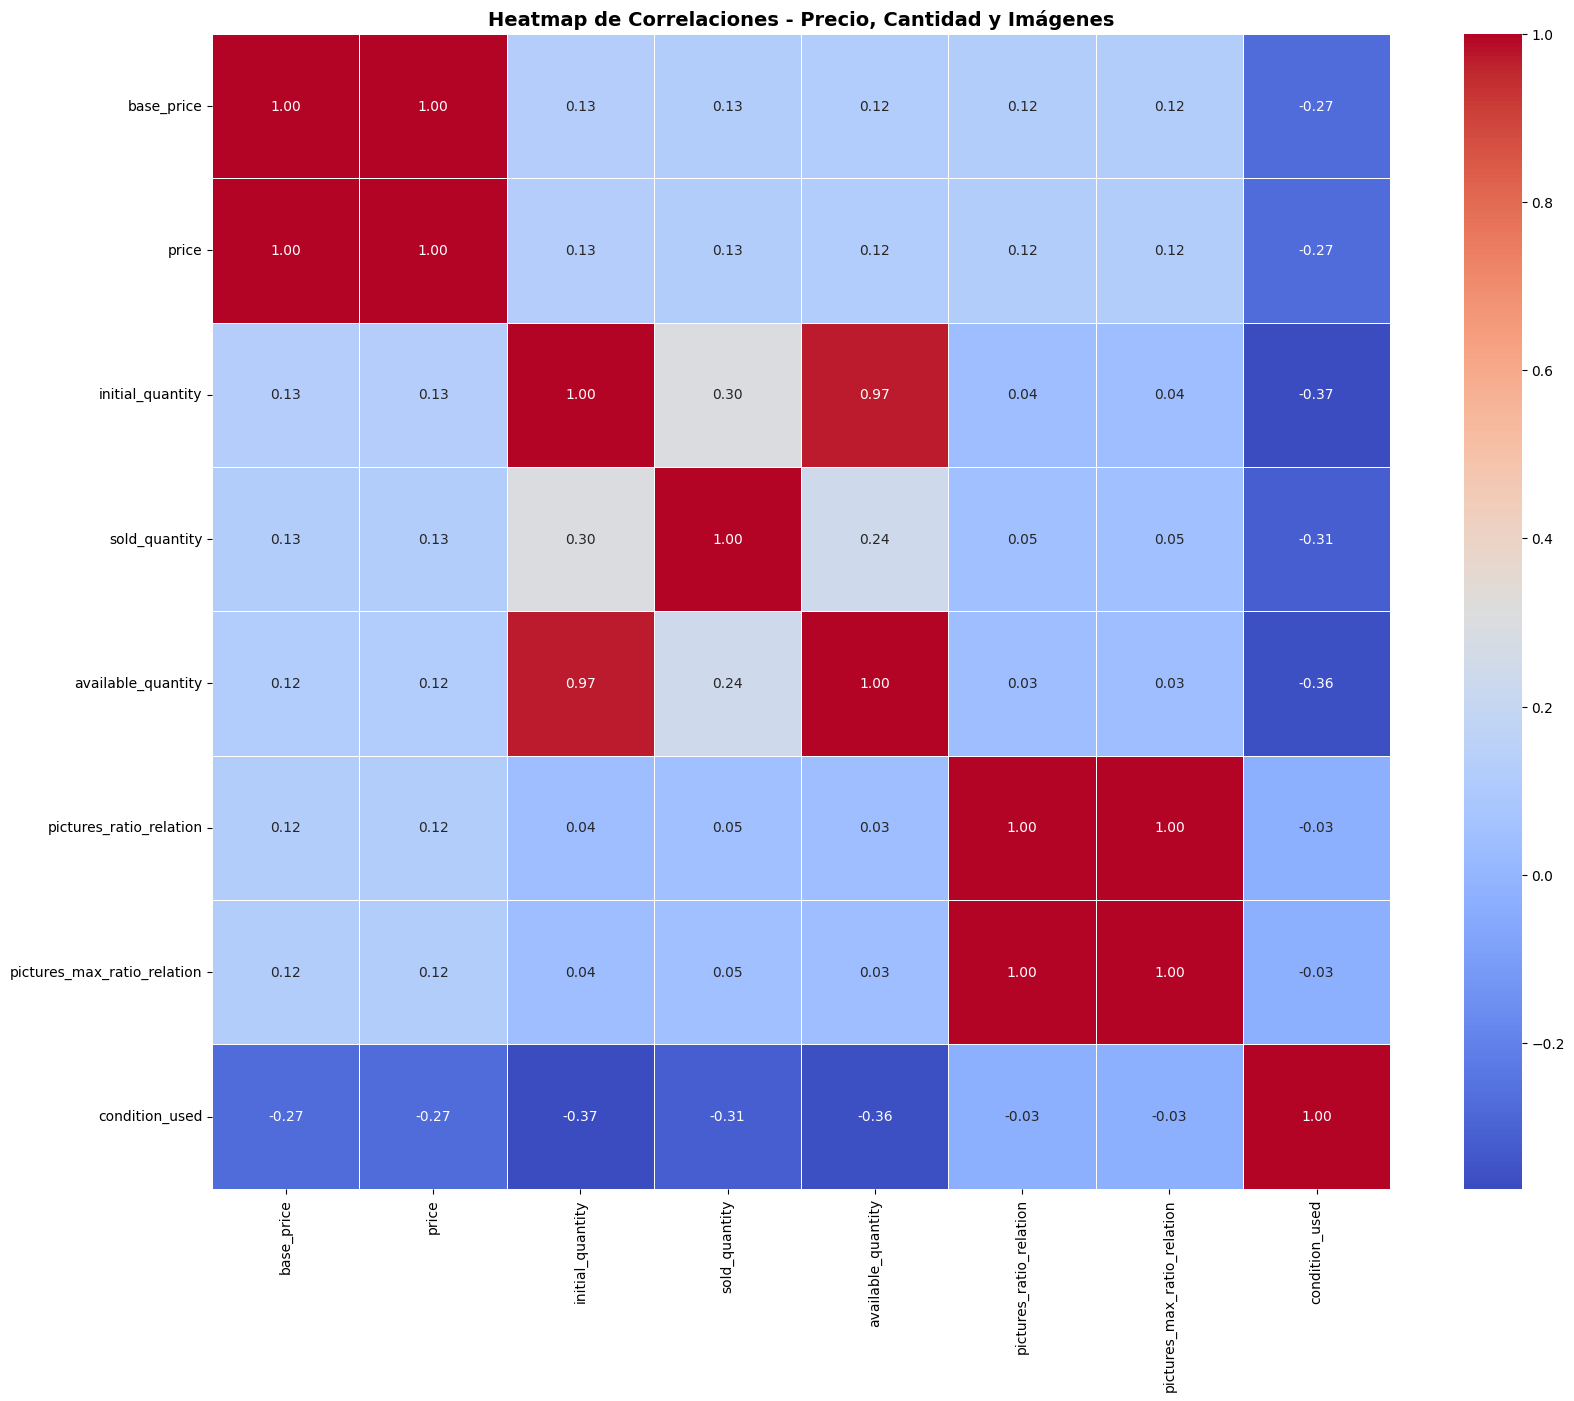

In [ ]:
top_vars_condition = get_top_correlated_vars(
    df_transformed[list(outlier_methods.keys()) + ['condition']],
    'conditio',
    method='spearman',
    top_n=10)

### 6.3 Ingnieria de caracteristicas

In [ ]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86947 entries, 0 to 89999
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   seller_address_state.name                     86947 non-null  object 
 1   seller_address_city.name                      86947 non-null  object 
 2   condition                                     86947 non-null  object 
 3   base_price                                    86947 non-null  float64
 4   shipping_local_pick_up                        86947 non-null  bool   
 5   shipping_free_shipping                        86947 non-null  bool   
 6   shipping_mode                                 86947 non-null  object 
 7   non_mercado_pago_payment_methods_description  86947 non-null  object 
 8   non_mercado_pago_payment_methods_type         86947 non-null  object 
 9   listing_type_id                               86947 non-null  obje

In [ ]:
%%time
import requests

# URL de la API para obtener todos los municipios de Argentina
# info https://www.datos.gob.ar/apis
url = "https://apis.datos.gob.ar/georef/api/municipios?max=5000"

response = requests.get(url)
data = response.json()

# Extraer la lista de municipios
municipios = data.get("municipios", [])
ciudades_ar = pd.DataFrame(municipios)
ciudades_ar["provincia_name"] = ciudades_ar["provincia"].apply(lambda x: x["nombre"])
ciudades_ar = ciudades_ar[['nombre', 'provincia_name']]
ciudades_ar

CPU times: user 40.8 ms, sys: 3.93 ms, total: 44.7 ms
Wall time: 1.43 s


nombre provincia_name
0     Benjamín Aráoz y El Tajamar        Tucumán
1              General Baldissera        Córdoba
2                          Impira        Córdoba
3                       Las Cejas        Tucumán
4                       La Cesira        Córdoba
...                           ...            ...
2077               Colonia Crespo     Entre Ríos
2078               Colonia Celina     Entre Ríos
2079                    San Pedro     Entre Ríos
2080             Rincón de Nogoyá     Entre Ríos
2081                     El Pingo     Entre Ríos

[2082 rows x 2 columns]

In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 14.1 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=52bd8489120009151b043bdb3422f902c6624e01f766aa18050430f6d41064a6
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [ ]:
import unicodedata
from rapidfuzz import process, fuzz
import swifter  # Para paralelización rápida

def normalize_text(text):
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')  # Quita tildes
    return text.lower().strip()

def find_best_match(city, city_dict, score_cutoff=70):
    """Encuentra la mejor coincidencia en base a similitud con RapidFuzz."""
    if not city:
        return None, 0  # Si la entrada es NaN o vacía

    normalized_cities = list(city_dict.keys())
    match = process.extractOne(city, normalized_cities, scorer=fuzz.ratio, score_cutoff=score_cutoff)

    if match:
        best_match, score = match[0], match[1]
        return city_dict[best_match], score  # Devuelve la ciudad oficial con tildes

    return city, 0  # Si no hay coincidencia, devuelve el original con score 0

def match_cities(df, column, city_dict):
    """Aplica la función de coincidencia sobre un DataFrame usando swifter."""
    df[[f"{column}_match", f"{column}_score"]] = df[column].swifter.apply(
        lambda x: pd.Series(find_best_match(x, city_dict))
    )
    return df

In [ ]:
# match provincias ar -----
df_transformed['seller_address_state.name_clean'] = df_transformed['seller_address_state.name'].apply(
        lambda text: clean_text(text, remove_sw=False, lemmatize=False, stem=False, use_regex=True, language='spanish'))

state_dict = {normalize_text(c): c for c in ciudades_ar["provincia_name"]}  # Guarda el original con tildes
df_transformed = match_cities(df_transformed, "seller_address_state.name_clean", state_dict)

# match ciudades ar -----
df_transformed['seller_address_city.name_clean'] = df_transformed['seller_address_city.name'].apply(
        lambda text: clean_text(text, remove_sw=False, lemmatize=False, stem=False, use_regex=True, language='spanish'))

ciudad_dict = {normalize_text(c): c for c in ciudades_ar["nombre"]}  # Guarda el original con tildes
df_transformed = match_cities(df_transformed, "seller_address_city.name_clean", ciudad_dict)

Pandas Apply:   0%|          | 0/86947 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/86947 [00:00<?, ?it/s]

In [ ]:
df_transformed.tail(10)

seller_address_state.name seller_address_city.name condition  \
89990           Capital Federal                     CABA      used   
89991           Capital Federal                  capital      used   
89992           Capital Federal                 Belgrano      used   
89993              Buenos Aires                  Florida       new   
89994                   Córdoba               Almafuerte       new   
89995           Capital Federal          capital federal      used   
89996           Capital Federal                    Núñez       new   
89997              Buenos Aires               La Matanza       new   
89998                    Chubut                   Trelew       new   
89999           Capital Federal                mataderos      used   

       base_price  shipping_local_pick_up  shipping_free_shipping  \
89990       65.00                    True                   False   
89991      250.00                    True                   False   
89992     1000.00                    True                   False   
89993      350.00                    True                   False   
89994     1200.00                   False                   False   
89995       68.00                   False                   False   
89996      126.00                    True                   False   
89997      300.00                    True                   False   
89998      696.58                   False                   False   
89999      470.00                    True                   False   

       shipping_mode non_mercado_pago_payment_methods_description  \
89990  not_specified                                     Efectivo   
89991            me2                                     Efectivo   
89992  not_specified                                     Efectivo   
89993  not_specified                                     Efectivo   
89994            me2                                     Efectivo   
89995            me2                                     Efectivo   
89996         custom                                     Efectivo   
89997  not_specified                                     Efectivo   
89998  not_specified                     Acordar con el comprador   
89999  not_specified                                     Efectivo   

      non_mercado_pago_payment_methods_type listing_type_id  ...  title_class  \
89990                                     G          bronze  ...         otro   
89991                                     G            free  ...         otro   
89992                                     G          bronze  ...         otro   
89993                                     G          bronze  ...         otro   
89994                                     G          bronze  ...         otro   
89995                                     G          bronze  ...        usado   
89996                                     G          bronze  ...         otro   
89997                                     G          bronze  ...        nuevo   
89998                                     G          bronze  ...         otro   
89999                                     G            free  ...         otro   

                                             title_clean  \
89990                            cuerpomente en deportes   
89991                      excelentes zuecos imperdibles   
89992  academia nacional de bellas artes 1878 1928 ci...   
89993  bateria 12n53b yamaha ybr 125 cc en wagner her...   
89994  mini vestidoremera de pailets super cool impor...   
89995     el fin de las libertades benegas lynch h usado   
89996            honda wave guardabarro interior trasero   
89997        my little pony completa latino 4 temporadas   
89998  accidente cerebrovascular en la infancia y ado...   
89999                  campera de mujer tucci reversible   

                categoria_predicha  len_title  \
89990           Deportes y Fitness         24   
89991    Boletas para Espectáculos         38   
89992   Arte, P

In [ ]:
print("Estados únicos antes:", len(df_transformed['seller_address_state.name'].unique()))
print("Estados únicos después:", len(df_transformed['seller_address_state.name_clean_match'].unique()))

print("Ciudades únicas antes:", len(df_transformed['seller_address_city.name'].unique()))
print("Ciudades únicas después:", len(df_transformed['seller_address_city.name_clean_match'].unique()))

Estados únicos antes: 24
Estados únicos después: 24
Ciudades únicas antes: 3441
Ciudades únicas después: 1658


In [ ]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86947 entries, 0 to 89999
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   seller_address_state.name                     86947 non-null  object 
 1   seller_address_city.name                      86947 non-null  object 
 2   condition                                     86947 non-null  object 
 3   base_price                                    86947 non-null  float64
 4   shipping_local_pick_up                        86947 non-null  bool   
 5   shipping_free_shipping                        86947 non-null  bool   
 6   shipping_mode                                 86947 non-null  object 
 7   non_mercado_pago_payment_methods_description  86947 non-null  object 
 8   non_mercado_pago_payment_methods_type         86947 non-null  object 
 9   listing_type_id                               86947 non-null  obje

In [ ]:
feature_engineering = ['warranty_class', 'pictures_area', 'pictures_max_area', 'pictures_ratio_relation', 'pictures_max_ratio_relation',
 'diff_price', 'time_since_last_update', 'title_class', 'categoria_predicha', 'len_title', 'seller_address_state.name_clean_match',
 'seller_address_city.name_clean_match']
feature = ['base_price', 'shipping_local_pick_up', 'shipping_free_shipping',
       'shipping_mode', 'non_mercado_pago_payment_methods_description',
       'non_mercado_pago_payment_methods_type', 'listing_type_id', 'price',
       'buying_mode', 'tags_0', 'accepts_mercadopago', 'automatic_relist',
       'status', 'initial_quantity', 'sold_quantity', 'available_quantity',
           'have_warranty', 'pictures_width', 'pictures_height',
       'pictures_max_width', 'pictures_max_height','time_to_start',
       'listing_duration'
]
target = ['condition']